# Titre projet

## Introduction

## Methodology

- on a des datas (120 variables) marcos de 1960 à 2025 - on séparer le train et le test set à partir de 2016 - on normalise en prenant les moments tu train sur le test et le train - on fait PCA en se basant sur le train mais en passant les datas du tests dans l'espace de dimension des PCA du train - on trouve des cluster de macros (2 à 6) grace à nos PCA sur le train - puis on fait du supervised sur l'ensemble (en entrainant PCA => régimes sur le train) pour que le modèle prédise des régime sur le test. - ces prédictions de régimes nous permettent de faire des prédictions de rendements puis portr

### Avoiding Look-Ahead Bias

Avoiding look-ahead bias became essential, as we had to carefully filter out biases present in both the datasets we used and the papers that inspired our approach.

**Look-ahead bias** occurs when a model, algorithm, or strategy uses information that would not have been available at the time the decision was made. Models that suffer from it appear profitable in backtests but cannot be implemented in real time, leading to misleading conclusions. In machine learning, this type of information leak is usually called data leakage, especially when future information leaks into the feature set.

**Incorrect temporal train/test separation**  
This source of look-ahead bias occurs when the model is trained on data points that would not have been available at the time predictions are supposed to be made. For example, if a dataset is randomly shuffled before splitting, future observations can accidentally enter the training set for earlier predictions. Another typical case is when hyperparameters are tuned using information spanning the entire dataset, meaning that the model indirectly “sees” the future during optimization.

**Preprocessing that uses future information**  
This happens when transformations such as scaling, normalization, dimensionality reduction, or quantile computation are fitted on the full dataset instead of only on past information. For instance, calculating the global mean and standard deviation before splitting allows future values to influence the transformation applied to earlier samples, giving the model an unrealistic advantage. Similarly, computing global bins for discretization or performing PCA on the entire dataset creates features that implicitly embed information from observations that occur later in time.

**Feature engineering that incorporates future observations**  
Feature leakage arises when features are built using windows or statistics that include future samples. A common situation is the use of centered rolling windows, which blend past and future values into a single feature even though the future part would not have been known at prediction time. Another example occurs when summary statistics such as future maxima, future averages, or future trends are computed and mistakenly treated as features available at the current timestamp.

**Misalignment between features and labels**  
Look-ahead bias also emerges when the temporal alignment between features and labels is off by one or more steps. This often comes from subtle indexing mistakes where the feature at time *t+1* is accidentally paired with the label at time *t*. Such misalignment can also occur when constructing rolling windows where the last element of the window unintentionally includes a future observation, causing the model to rely on information that it should not have access to.

**Using revised, corrected, or future-derived data**  
Some datasets evolve over time due to updates, corrections, revisions, or restatements, and using the fully corrected dataset in retrospect can create hidden leakage. For example, if missing values are filled using global information, or if anomalies are detected and treated using statistics computed over the full dataset, then early samples end up depending on information that involves later observations. This type of look-ahead bias is subtle because it can occur even when the temporal split is done correctly, but the data itself implicitly contains future knowledge. Another frequent issue comes from values associated with a specific timestamp, which have been published days, weeks, or even months after that timestamp. 

**Evaluation procedures that allow future information to influence model design**  
Look-ahead bias can also result from evaluation methodologies that unintentionally let future outcomes affect earlier decisions. A typical example is performing model selection or feature selection using the full time span, which means that performance metrics computed on future samples guide choices applied to past samples. Another example occurs when cross-validation folds are created without respecting temporal order, causing the model to be exposed to patterns that only appear later in the sequence and therefore overstating its true predictive performance.

A major source of concern in empirical studies using FRED-MD is the widespread presence of look-ahead bias, which often arises because many academic works implicitly treat macroeconomic variables as if they were known in real time. In practice, however, these series are subject to publication lags and subsequent revisions, meaning that their “final” values were not available to investors at the time decisions were made. To partially mitigate this issue, we shift a subset of the macroeconomic variables by one month relative to the financial data, so that the information set used for prediction more closely reflects what would have been observable in real time. 

Furthermore, we avoid additional look-ahead bias by performing all preprocessing steps strictly within the training sample: both the standardization of the variables and the PCA decomposition are fitted exclusively on the training set and then applied to the test set. This ensures that no future information leaks into the model during feature construction.

In [ ]:
from fredapi import Fred
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
from numpy.linalg import svd

import pandas as pd
from pathlib import Path
import re
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import seaborn as sns

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, log_loss
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize

from scipy.spatial.distance import cdist
from scipy.special import expit

from typing import Optional, Dict, Tuple
import os

# from skfin.dataloaders.cache import CacheManager


## Data preprocessing

### FRED-MD dataset

The FRED-MD dataset (Federal Reserve Economic Data – Monthly Database) is a widely used macroeconomic dataset maintained by the Federal Reserve Bank of St. Louis. It contains a broad panel of monthly U.S. macroeconomic and financial time series, covering areas such as output, labor markets, housing, consumption, inflation, interest rates, and asset prices. Each column represents one macroeconomic variable, while rows correspond to monthly observations. The first row of the dataset provides transformation codes, which specify how each series should be transformed (for example, log, first difference, or growth rate) before analysis to ensure stationarity. The dataset is updated monthly and is commonly used in empirical macroeconomic research, forecasting, and machine learning applications in finance and economics.

In [136]:
# --- Load main dataset (FRED-MD monthly macro data) ---
url_data = "https://raw.githubusercontent.com/lxsd111/ML_PM/main/nbs/data/2025-09-MD.csv"
fred = pd.read_csv(url_data, index_col=0)

# --- Separate transformation "tcodes" (first row) and actual data (remaining rows) ---
fred_data = fred.iloc[1:,:].copy()
fred_code = fred.iloc[0,:].copy()

# --- Convert index to datetime ---
fred_data.index = pd.to_datetime(fred_data.index, format='mixed')
print(fred_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 800 entries, 1959-01-01 to 2025-08-01
Columns: 126 entries, RPI to VIXCLSx
dtypes: float64(102), int64(24)
memory usage: 793.8 KB
None


The FRED-MD dataset contains 800 monthly observations ranging from January 1959 to August 2025, covering 126 macroeconomic variables. Among these variables, 102 are stored as floating-point values and 24 as integers, representing a diverse set of economic and financial indicators.

This preprocessing step aims to partially address publication lag issues in the FRED-MD dataset — i.e., the fact that some macroeconomic indicators are released with delays relative to others. For each remaining series, the code identifies how many missing values (NaN) appear at the end of the sample, which typically reflects unavailable recent data. Each affected series is then shifted forward by the corresponding number of months, effectively aligning its last valid observation with the latest available period. This ensures a more realistic timing structure by avoiding the use of data that would not have been known at the time (reducing look-ahead bias). Finally, the sample is restricted to observations starting from May 1962 to ensure consistency across variables. Moreover, a few variables with too many missing values (ACOGNO, TWEXAFEGSMTHx, UMCSENTx, ANDENOx) are removed from the dataset.

In [137]:
# --- Drop variables with too many missing values ---
cols_to_drop = ["ACOGNO", "TWEXAFEGSMTHx", "UMCSENTx", "ANDENOx"]
fred_data = fred_data.drop(columns=cols_to_drop, errors="ignore").copy()

# --- Function: count consecutive NaN values at the end of a series ---
def trailing_nans(s: pd.Series) -> int:
    """Count the number of consecutive NaN values at the end of a Series."""
    if not s.isna().any():
        return 0
    return int(np.argmax(~s[::-1].isna().values)) if s.isna().any() else 0

# --- Identify variables with trailing NaNs ---
nan_trails = {col: trailing_nans(fred_data[col]) for col in fred_data.columns}
nan_trails = {k: v for k, v in nan_trails.items() if v > 0}

# --- Shift series forward by 'n' months if they have n trailing NaNs ---
for col, lag in nan_trails.items():
    if lag > 0:
        fred_data[col] = fred_data[col].shift(lag)

# --- Restrict the sample to ensure consistent coverage across variables ---
fred_data = fred_data.loc[fred_data.index >= "1962-05-01"]

print(f"\nFinal dataset size: {fred_data.shape[0]} observations, {fred_data.shape[1]} variables")


Final dataset size: 760 observations, 122 variables


Apart from VIX, the dataset contained only two missing values, which we handled with forward fill (ffill). Any remaining NaNs are in VIX and will be treated later during the transformation step.

In [138]:
fred_data = fred_data.fillna(method="ffill")

C:\Users\user\AppData\Local\Temp\ipykernel_108416\2309531013.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fred_data = fred_data.fillna(method="ffill")


Each variable in the **FRED-MD** dataset is associated with a *transformation code* (`tcode`), which specifies how the raw series should be transformed before analysis to achieve stationarity and comparability across variables.  

The transformation rules, as defined by McCracken and Ng (2016), are as follows:

| Code | Transformation | Description |
|:----:|:------------------------------|:-----------------------------------------------|
| 1 | *No transformation* | Use the level of the series as is |
| 2 | $\Delta x_t$ | First difference of the raw series |
| 3 | $\Delta^2 x_t$ | Second difference of the raw series |
| 4 | $\log(x_t)$ | Natural logarithm of the level |
| 5 | $\Delta \log(x_t)$ | First difference of the logarithm (approximate growth rate) |
| 6 | $\Delta^2 \log(x_t)$ | Second difference of the logarithm |
| 7 | $\Delta \left(\frac{x_t}{x_{t-1}} - 1\right)$ | Change in the growth rate (ratio form) |

These transformations are applied to ensure that most macroeconomic series are **stationary** before being used in empirical models such as factor analysis or forecasting.  
Variables marked with an asterisk (*) in the FRED-MD documentation indicate that minor adjustments were made relative to their original FRED source (see McCracken & Ng, *"FRED-MD: A Monthly Database for Macroeconomic Research"*, 2016).


In [139]:
# --- Normalize column names to ensure alignment between data and codes ---
fred_data.columns = fred_data.columns.str.upper()
# fred_code is a single-row DataFrame or a Series with tcodes per column
tcode_map = fred_code.squeeze()                    # to Series if single row
tcode_map.index = tcode_map.index.str.upper()      # align names
tcode_map = pd.to_numeric(tcode_map, errors="coerce")

# --- Container for transformed series ---
df_transformed = pd.DataFrame(index=fred_data.index)

# --- Apply McCracken–Ng tcodes where available; otherwise keep series as is ---
for col in fred_data.columns:
    s = fred_data[col]
    code = tcode_map.get(col, np.nan)  # NaN => no code available

    if pd.isna(code):
        # No transformation code: keep original series
        s_tr = s
    else:
        code = int(code)
        if code == 1:
            s_tr = s
        elif code == 2:
            s_tr = s.diff()
        elif code == 3:
            s_tr = s.diff().diff()
        elif code == 4:
            # Log of levels; guard against non-positive values
            s_tr = s.where(s > 0)
            s_tr = np.log(s_tr)
        elif code == 5:
            # First difference of log (approximate growth rate)
            s_tr = s.where(s > 0)
            s_tr = np.log(s_tr).diff()
        elif code == 6:
            # Second difference of log
            s_tr = s.where(s > 0)
            s_tr = np.log(s_tr).diff().diff()
        else:
            # Δ(x_t / x_{t-1} - 1)
            r = s / s.shift(1) - 1
            s_tr = r.diff()

    df_transformed[col] = s_tr

C:\Users\user\AppData\Local\Temp\ipykernel_108416\3549416829.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_transformed[col] = s_tr
C:\Users\user\AppData\Local\Temp\ipykernel_108416\3549416829.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_transformed[col] = s_tr
C:\Users\user\AppData\Local\Temp\ipykernel_108416\3549416829.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once 

In [ ]:
# List of selected variables
cols_bis = [
    "RPI", "UNRATE", "CLAIMSX", "HOUST", "PERMIT", "DPCERA3M086SBEA",
    "ISRATIOX", "M1SL", "M2SL", "BOGMBASE", "NONBORRES", "CONSPI",
    "BUSLOANS", "FEDFUNDS", "T1YFFM", "T5YFFM", "T10YFFM", "AAAFFM",
    "BAAFFM", "OILPRICEX", "CPIAUCSL", "CUSR0000SAS",
    "S&P 500", "S&P DIV YIELD", "S&P PE RATIO", "VIXCLSX"
]

# Extract the reduced dataset
df_bis = df_transformed[cols_bis].copy()

# Overview of dimensions and sample rows
print(df_bis.shape)
df_bis.head()

(760, 26)


,RPI,UNRATE,CLAIMSX,HOUST,PERMIT,DPCERA3M086SBEA,ISRATIOX,M1SL,M2SL,BOGMBASE,...,T10YFFM,AAAFFM,BAAFFM,OILPRICEX,CPIAUCSL,CUSR0000SAS,S&P 500,S&P DIV YIELD,S&P PE RATIO,VIXCLSX
sasdate,,,,,,,,,,,,,,,,,,,,,
1962-05-01,NaN,NaN,NaN,7.301822,7.040536,NaN,NaN,NaN,NaN,NaN,...,1.51,1.92,2.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-06-01,0.001380,0.0,0.019957,7.247081,7.050989,-0.005022,0.010331,NaN,NaN,NaN,...,1.23,1.60,2.34,NaN,NaN,NaN,-0.124253,0.105335,-0.084937,NaN
1962-07-01,0.004832,-0.1,-0.009222,7.279319,7.080868,0.003215,0.020662,0.000681,-0.000881,-0.000062,...,1.30,1.63,2.34,0.0,0.001324,0.003992,0.023802,0.252174,-0.133255,19.5715
1962-08-01,0.001608,0.3,0.006121,7.324490,7.090077,0.002797,0.000000,0.001365,0.001400,-0.009779,...,1.05,1.42,2.13,0.0,0.001653,-0.003992,0.026844,0.443267,0.010199,15.7942
1962-09-01,0.000470,-0.1,-0.015853,7.188413,7.109062,0.011112,-0.010331,-0.002731,0.000250,0.003902,...,1.08,1.42,2.13,0.0,0.002629,0.000000,-0.008926,-0.075392,0.016086,18.3148


Applying the transformations resulted in the loss of the first two observations — since differencing operations (Δxₜ, Δ²xₜ, etc.) naturally reduce the sample size — so the dataset now starts in July 1962.

The dataset is then split at January 2016: this cutoff is economically meaningful, as it separates the post–Global Financial Crisis and monetary normalization period from earlier decades, while also providing a sufficiently large historical window for robust machine learning tasks such as clustering, dimensionality reduction, and model training.

In [141]:
# --- Define temporal boundaries for the analysis ---
START_DATE = "1962-07-01"   
END_DATE   = "2025-08-01"  
SPLIT_DATE = "2016-01-01"   # split point for in-sample (IS) vs out-of-sample (OOS)

# Restrict dataset to the analysis period
df_transformed = df_transformed.loc[df_transformed.index >= START_DATE]

# --- Split the dataset into in-sample (IS) and out-of-sample (OOS) periods ---
fred_IS  = df_transformed.loc[:SPLIT_DATE].copy()   
fred_OOS = df_transformed.loc[SPLIT_DATE:].copy()   

fred_IS_bis = df_bis.loc[START_DATE:SPLIT_DATE].copy()
fred_OOS_bis = df_bis.loc[SPLIT_DATE:END_DATE].copy()

The data are standardized using a StandardScaler, which removes the mean and scales each feature to unit variance — a necessary step for PCA, since principal components are sensitive to variable magnitudes. The scaler is fitted on the in-sample (IS) data to capture the historical distribution of each variable, and then applied to the out-of-sample (OOS) data to ensure consistent scaling without leaking future information.

In [142]:
# --- Standardize the data (zero mean, unit variance) ---
scaler = StandardScaler()

fred_IS_std = pd.DataFrame(
    scaler.fit_transform(fred_IS),
    index=fred_IS.index,
    columns=fred_IS.columns
)

fred_OOS_std = pd.DataFrame(
    scaler.transform(fred_OOS),
    index=fred_OOS.index,
    columns=fred_OOS.columns
)

# --- Dataset "bis" ---
scaler_bis = StandardScaler()
train_std_bis = pd.DataFrame(
    scaler_bis.fit_transform(fred_IS_bis),
    index=fred_IS_bis.index,
    columns=fred_IS_bis.columns
)

test_std_bis = pd.DataFrame(
    scaler_bis.transform(fred_OOS_bis),  # moments de train_bis seulement
    index=fred_OOS_bis.index,
    columns=fred_OOS_bis.columns
)

### Industry Portfolios

The 12 Industry Portfolios from Kenneth French’s data library provide monthly returns for twelve broad U.S. industry groups, constructed using firms listed on major U.S. exchanges and sorted based on their SIC codes. Each column corresponds to an industry portfolio (such as Consumer Durables, Manufacturing, Energy, Chemicals, etc.), and the values represent value-weighted returns expressed in percentage form. 

This section loads the 12 Industry Portfolios from Kenneth French’s data library, cleans the dataset, and prepares it for empirical analysis. The sample is divided into an in-sample period used for model estimation and an out-of-sample period reserved for evaluating predictive performance. 

In [143]:
# URL to the ZIP file containing Ken French's 12 Industry Portfolios
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/12_Industry_Portfolios_CSV.zip"

# Load the CSV file 
indus_df = pd.read_csv(url, skiprows=11)
indus_df.columns.values[0] = "Date"
indus_df.set_index("Date", inplace=True)

# Keep only the monthly observations up to row 1191 (before missing values appear)
indus_df = indus_df.iloc[:1191].copy()
indus_df.index = pd.to_datetime(indus_df.index.astype(str), format="%Y%m")
indus_df = indus_df.astype(float) / 100.0

# Split the dataset into in-sample (IS) and out-of-sample (OOS)
indus_all  = indus_df.loc[START_DATE:].astype(float).copy()
indus_IS  = indus_df.loc[START_DATE:SPLIT_DATE].astype(float).copy()
indus_OOS = indus_df.loc[SPLIT_DATE:END_DATE].astype(float).copy()

# Simple cumulative sum (additive approximation)
indus_cum = indus_df.cumsum()

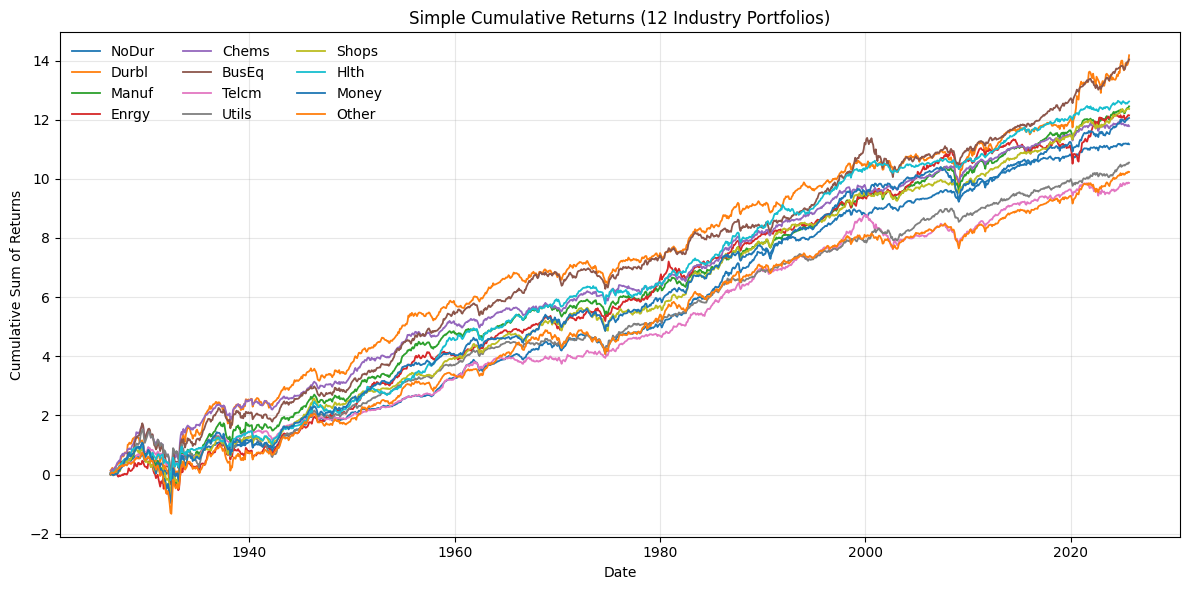

In [144]:
plt.figure(figsize=(12,6))
for c in indus_cum.columns:
    plt.plot(indus_cum.index, indus_cum[c], label=c, lw=1.3)

plt.title("Simple Cumulative Returns (12 Industry Portfolios)")
plt.xlabel("Date")
plt.ylabel("Cumulative Sum of Returns")
plt.legend(ncol=3, frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Fama–French style factors

The factor data are sourced from Kenneth French’s Data Library, which provides long-horizon, research-grade monthly time series widely used in empirical asset pricing. The dataset includes five well-known Fama–French style factors: **SMB**, **HML**, **RMW**, **CMA**, and **MOM**, each representing a distinct compensated source of risk in cross-sectional equity returns. **SMB** (Small Minus Big) captures the size premium by measuring the performance spread between small-cap and large-cap stocks. **HML** (High Minus Low) reflects the value premium by comparing returns of high book-to-market firms to low book-to-market firms. **RMW** (Robust Minus Weak) measures the profitability premium, contrasting firms with strong operating profitability against those with weak profitability. **CMA** (Conservative Minus Aggressive) represents the investment premium based on differences in corporate investment policies. Finally, **MOM** (Momentum) captures the well-documented tendency for stocks with strong past performance to continue outperforming in the near term. Together, these factors form a comprehensive framework for explaining and modeling the cross-section of expected equity returns.


In [145]:
# Fama-French 5 Factors + Momentum (MKT, SMB, HML, RMW, CMA, MOM)
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
ff5 = pd.read_csv(url, skiprows=3)

# Clean column names and keep only rows corresponding to YYYYMM dates
ff5 = ff5.rename(columns={ff5.columns[0]: "Date"})
ff5.columns = ff5.columns.str.strip()
ff5 = ff5[ff5["Date"].astype(str).str.fullmatch(r"\d{6}", na=False)].copy()

# Convert the Date column to datetime and set it as index
ff5["Date"] = pd.to_datetime(ff5["Date"], format="%Y%m")
ff5 = ff5.set_index("Date")

# Convert all factor values from percent to decimal
ff5 = ff5.astype(float) / 100  

# --- Momentum (MOM) ---
url_mom = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip"
mom = pd.read_csv(url_mom, skiprows=13)

# Clean column names and the Date column
mom = mom.rename(columns={mom.columns[0]: "Date"})
mom.columns = mom.columns.str.strip()

# Keep only rows corresponding to YYYYMM dates (ignore invalid rows)
mom = mom[mom["Date"].astype(str).str.fullmatch(r"\d{6}", na=False)].copy()

# Convert Date to datetime and numerical values to floats
mom["Date"] = pd.to_datetime(mom["Date"], format="%Y%m")
mom = mom.set_index("Date")
mom = mom.apply(pd.to_numeric, errors="coerce") / 100

# Standardize the momentum column name (e.g., "Mom", " MOM ")
mom.columns = mom.columns.str.strip()
mom = mom.rename(columns={mom.columns[0]: "MOM"})

# --- Merge FF5 and Momentum ---
factors = ff5.join(mom[["MOM"]], how="inner")

# Drop excess columns (market excess return and risk-free rate)
factors = factors.drop(['Mkt-RF', 'RF'], axis=1)

# Split into in-sample (IS) and out-of-sample (OOS) windows
factors_all  = factors.loc[START_DATE:END_DATE].copy()
factors_IS  = factors.loc[START_DATE:SPLIT_DATE].copy()
factors_OOS = factors.loc[SPLIT_DATE:END_DATE].copy()
print(factors_all.head())

               SMB     HML     RMW     CMA     MOM
Date                                              
1963-07-01 -0.0048 -0.0081  0.0064 -0.0115  0.0101
1963-08-01 -0.0080  0.0170  0.0040 -0.0038  0.0100
1963-09-01 -0.0043  0.0000 -0.0078  0.0015  0.0012
1963-10-01 -0.0134 -0.0004  0.0279 -0.0225  0.0313
1963-11-01 -0.0085  0.0173 -0.0043  0.0227 -0.0078


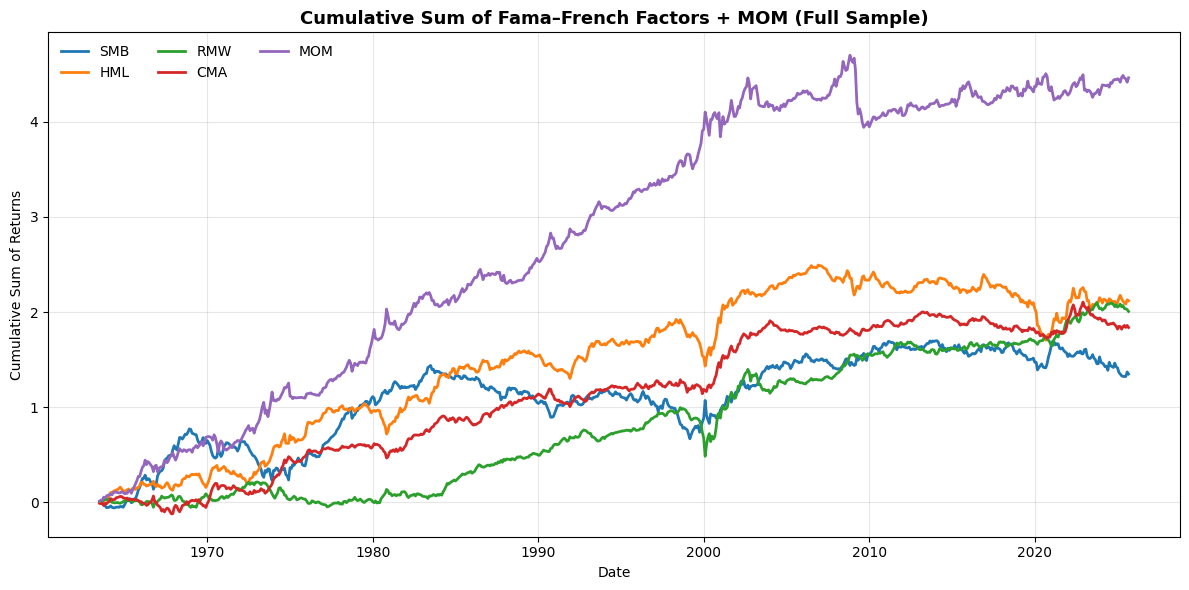

In [146]:
# Compute cumulative sums of all factor returns (already in decimal form)
ff_cum = factors.cumsum()

# Use all columns from the factors dataset
factor_cols = factors.columns

# Plot
plt.figure(figsize=(12,6))
palette = sns.color_palette("tab10", n_colors=len(factor_cols))

for i, col in enumerate(factor_cols):
    plt.plot(ff_cum.index, ff_cum[col], label=col, lw=2, color=palette[i % len(palette)])

plt.title("Cumulative Sum of Fama–French Factors + MOM (Full Sample)",
          fontsize=13, weight="bold")
plt.xlabel("Date")
plt.ylabel("Cumulative Sum of Returns")
plt.grid(alpha=0.3)
plt.legend(frameon=False, ncol=3)
plt.tight_layout()
plt.show()


**Summary of Useful DataFrames :**

indus_all — full DataFrame of monthly returns for the 12 Industry Portfolios.

indus_IS — in-sample DataFrame of industry returns (training window).

indus_OOS — out-of-sample DataFrame of industry returns (evaluation window).

factors_all — full DataFrame of Fama–French + Momentum factors.

factors_IS — in-sample DataFrame of explanatory factors.

factors_OOS — out-of-sample DataFrame of explanatory factors.

fred_IS — Full FRED dataset over the in-sample period.

fred_OOS — Full FRED dataset over the out-of-sample period.

fred_IS_bis — Selected subset of FRED variables for the in-sample period.

fred_OOS_bis — Selected subset of FRED variables for the out-of-sample period.




## Macroeconomic Regime Detection

### Principal Component Analysis

We apply PCA on the training set to reduce the dimensionality of the macroeconomic dataset while retaining at least 85% of the total variance. This provides a compact set of orthogonal factors that capture the dominant sources of macroeconomic co-movement and improves the stability of downstream clustering and prediction.

Number of components retained: 41
Cumulative explained variance: 85.43%


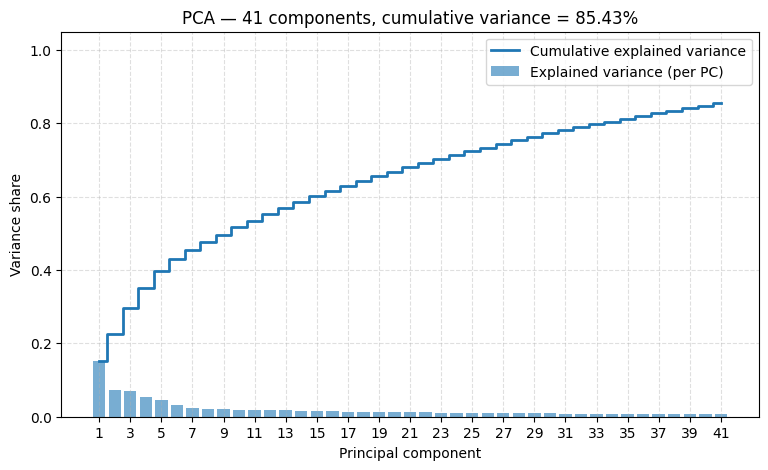

In [ ]:
# Keep the minimum number of components explaining at least 85% of the variance
pca = PCA(n_components=0.85, svd_solver='full')

# --- Fit PCA on TRAIN only ---
# This learns the eigenvectors/eigenvalues from the training set
fred_PCA_IS = pd.DataFrame(
    pca.fit_transform(fred_IS_std),        # fit + transform on TRAIN
    index=fred_IS_std.index,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

print(f"Number of components retained: {pca.n_components_}")
print(f"Cumulative explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# --- Out-of-sample projection of TEST ---
# We apply the TRAIN PCA transformation to the TEST data (no refitting)
fred_PCA_OOS = pd.DataFrame(
    pca.transform(fred_OOS_std),           # pure transform on TEST
    index=fred_OOS_std.index,
    columns=fred_PCA_IS.columns
)

# (Optional) Reconstruct a full PCA series (TRAIN + TEST) in the same PCA space
fred_PCA = pd.concat([fred_PCA_IS, fred_PCA_OOS]).sort_index()

evr = pca.explained_variance_ratio_         # variance explained by each PC
evr_cum = np.cumsum(evr)                    # cumulative explained variance
k = pca.n_components_

plt.figure(figsize=(9, 5))

# Variance explained per component
plt.bar(np.arange(1, k+1), evr, alpha=0.6, label='Explained variance (per PC)')

# Cumulative explained variance curve
plt.step(np.arange(1, k+1), evr_cum, where='mid', linewidth=2.0,
         label='Cumulative explained variance')

plt.xlabel('Principal component')
plt.ylabel('Variance share')
plt.title(f'PCA — {k} components, cumulative variance = {evr_cum[-1]:.2%}')
plt.xticks(np.arange(1, k+1, max(1, k//20)))
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.show()
plt.close()


### Partie GMM



=== Critères par k (TRAIN) ===
      loglik           AIC           BIC         ENT           ICL
k                                                                 
3 -67.233431  86957.689467  88065.293359  -33.174440  88131.642240
2 -67.792996  87511.588797  88248.502676  -31.491055  88311.484786
4 -67.045492  86882.346021  88360.639925  -65.310528  88491.260980
5 -66.797086  86728.643590  88577.627506 -129.633961  88836.895427
6 -66.582792  86618.514958  88838.188886 -153.852457  89145.893800


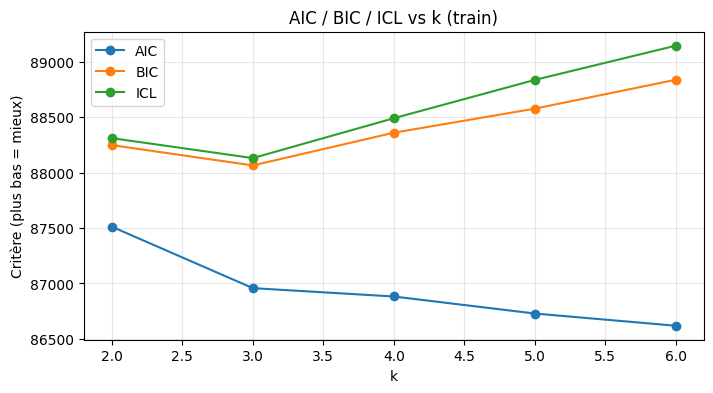

sasdate
2015-09-01    0
2015-10-01    2
2015-11-01    2
2015-12-01    2
2016-01-01    5
Name: gmm_label, dtype: int64


In [ ]:
# === 1) Calcule et affiche les critères pour k in [2..5] ===
k_candidates = range(2, 7)
rows = []
models = {}

for k_ in k_candidates:
    g = GaussianMixture(
        n_components=k_,
        covariance_type="diag",
        n_init=10,
        reg_covar=1e-6,
        random_state=42
    ).fit(fred_PCA_IS)

    bic = g.bic(fred_PCA_IS)
    aic = g.aic(fred_PCA_IS)
    tau = np.clip(g.predict_proba(fred_PCA_IS), 1e-12, 1.0)
    ent = (tau * np.log(tau)).sum()          # ENT <= 0
    icl = bic - 2.0 * ent                    # ICL à minimiser

    rows.append({"k": k_, "loglik": g.lower_bound_, "AIC": aic, "BIC": bic, "ENT": ent, "ICL": icl})
    models[k_] = g

ic_df = pd.DataFrame(rows).set_index("k")
print("\n=== Critères par k (TRAIN) ===")
print(ic_df.sort_values("ICL"))

# (optionnel) petit plot pour t’aider à choisir
plt.figure(figsize=(8,4))
for col in ["AIC","BIC","ICL"]:
    plt.plot(ic_df.index, ic_df[col], marker='o', label=col)
plt.xlabel("k"); plt.ylabel("Critère (plus bas = mieux)")
plt.title("AIC / BIC / ICL vs k (train)")
plt.grid(alpha=0.3); plt.legend(); plt.show()

# === 2) Choix manuel du nombre de régimes ===
chosen_k = 6  # <-- mets la valeur que TU veux
gmm = models[chosen_k]

# Sécurité : si tu préfères refitter proprement (mêmes hyperparams) :
# gmm = GaussianMixture(n_components=chosen_k, covariance_type="diag",
#                       n_init=10, reg_covar=1e-6, random_state=42).fit(X_pca_train)

if hasattr(gmm, "converged_") and not gmm.converged_:
    print("GMM non convergé.")

# === 3) Prédictions (train) ===
labels_tr = gmm.predict(fred_PCA_IS)
probas_tr = gmm.predict_proba(fred_PCA_IS)
llk_tr    = gmm.score_samples(fred_PCA_IS)

# construit la série indexée pour tes plots
dates_train = fred_PCA_IS.index



reg_gmm_IS = pd.Series(labels_tr, index=dates_train, name="gmm_label").astype(int)

print(reg_gmm_IS.tail())


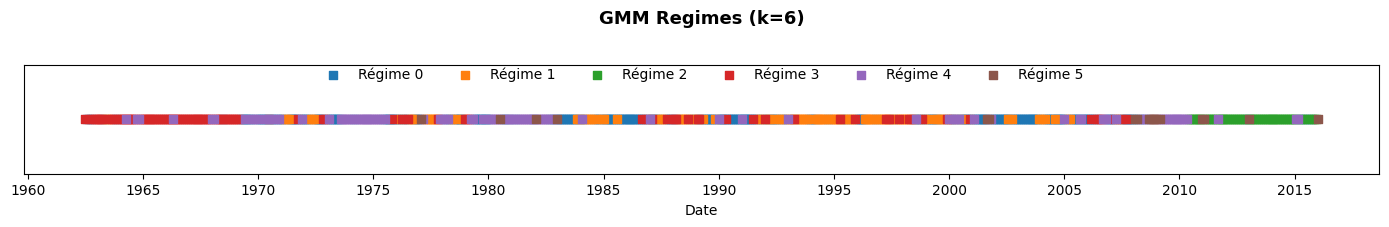

In [ ]:
# --- Données : extraire les labels et l'index temps ---
dates = reg_gmm_IS.index

# --- Palette cohérente ---
n_regimes = reg_gmm_IS.max() + 1
palette = sns.color_palette("tab10", n_colors=n_regimes)

# --- Figure principale ---
fig, ax = plt.subplots(figsize=(14, 2.5))
ax.set_title(f"GMM Regimes (k={n_regimes})", fontsize=13, weight="bold")

# Plot des points colorés (timeline horizontale)
for k_ in range(n_regimes):
    idx_k = reg_gmm_IS[reg_gmm_IS == k_].index
    ax.scatter(idx_k, [0]*len(idx_k), s=30, color=palette[k_], label=f"Régime {k_}", marker="s")


# Mise en forme
ax.set_yticks([])
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.grid(False)

# Légende centrée
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.25),
    ncol=n_regimes,
    frameon=False
)

ax.set_title(f"GMM Regimes (k={n_regimes})", fontsize=13, weight="bold", pad=30)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.10), ncol=n_regimes, frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:

# Log-likelihood global
loglik_train = gmm.score(fred_PCA_IS) * len(fred_PCA_IS)
aic = gmm.aic(fred_PCA_IS)
bic = gmm.bic(fred_PCA_IS)

# Probabilités d’appartenance
tau = gmm.predict_proba(fred_PCA_IS)

# Entropie moyenne
entropy_mean = -(tau * np.log(tau + 1e-12)).sum(axis=1).mean()

# Pureté moyenne
purity_mean = np.mean(tau.max(axis=1))

print("\n=== Qualité du GMM (Train) ===")
print(f"Log-likelihood total : {loglik_train:,.2f}")
print(f"AIC : {aic:,.2f}")
print(f"BIC : {bic:,.2f}")
print(f"Entropie moyenne : {entropy_mean:.4f}")
print(f"Pureté moyenne   : {purity_mean:.4f}")

# ======================================================
# 2. Évaluation sur le jeu de test (si disponible)
# ======================================================

try:
    loglik_test = gmm.score(fred_PCA_OOS) * len(fred_PCA_OOS)
    tau_test = gmm.predict_proba(fred_PCA_OOS)
    entropy_test = -(tau_test * np.log(tau_test + 1e-12)).sum(axis=1).mean()
    purity_test = np.mean(tau_test.max(axis=1))

    print("\n=== Généralisation (Test) ===")
    print(f"Log-likelihood total (test) : {loglik_test:,.2f}")
    print(f"Entropie moyenne (test) : {entropy_test:.4f}")
    print(f"Pureté moyenne (test)   : {purity_test:.4f}")
    print(f"Δ LogLik (test - train) : {loglik_test - loglik_train:,.2f}")

except Exception as e:
    print("\n(Aucun jeu de test détecté ou erreur lors de l’évaluation)")
    print(e)

# ======================================================
# 3. Stabilité temporelle / structurelle (optionnel)
# ======================================================

# Exemple : comparer les régimes sur 2 sous-périodes du train
split = len(fred_PCA_IS) // 2
idx_1 = fred_PCA_IS.index[:split]
idx_2 = fred_PCA_IS.index[split:]

gmm_1 = GaussianMixture(
    n_components=chosen_k, covariance_type="diag",
    n_init=10, reg_covar=1e-6, random_state=42
).fit(fred_PCA_IS.loc[idx_1])

labels_1 = gmm_1.predict(fred_PCA_IS.loc[idx_1])
labels_2 = gmm.predict(fred_PCA_IS.loc[idx_2])


=== Qualité du GMM (Train) ===
Log-likelihood total : -42,812.26
AIC : 86,618.51
BIC : 88,838.19
Entropie moyenne : 0.2393
Pureté moyenne   : 0.9120

=== Généralisation (Test) ===
Log-likelihood total (test) : -13,716.14
Entropie moyenne (test) : 0.4300
Pureté moyenne (test)   : 0.8346
Δ LogLik (test - train) : 29,096.12


In [151]:
min_len = min(len(labels_1), len(labels_2))

labels1_common = labels_1[-min_len:]
labels2_common = labels_2[-min_len:]

ari = adjusted_rand_score(labels1_common, labels2_common)
nmi = normalized_mutual_info_score(labels1_common, labels2_common)

print("\n=== Stabilité des régimes ===")
print(f"Adjusted Rand Index (ARI) : {ari:.3f}")
print(f"Normalized Mutual Info (NMI) : {nmi:.3f}")


print("\n=== Stabilité des régimes ===")
print(f"Adjusted Rand Index (ARI) : {ari:.3f}")
print(f"Normalized Mutual Info (NMI) : {nmi:.3f}")

# ======================================================
# 4. Synthèse rapide
# ======================================================

summary = pd.DataFrame({
    "Metric": ["LogLik_train", "AIC", "BIC", "Entropy", "Purity"],
    "Value": [loglik_train, aic, bic, entropy_mean, purity_mean]
})
print("\n=== Résumé synthétique ===")
display(summary)


=== Stabilité des régimes ===
Adjusted Rand Index (ARI) : 0.030
Normalized Mutual Info (NMI) : 0.075

=== Stabilité des régimes ===
Adjusted Rand Index (ARI) : 0.030
Normalized Mutual Info (NMI) : 0.075

=== Résumé synthétique ===


,Metric,Value
0,LogLik_train,-42812.257479
1,AIC,86618.514958
2,BIC,88838.188886
3,Entropy,0.239273
4,Purity,0.911952


In [152]:

X_bis_train = fred_IS_bis.copy()
X_bis_test  = fred_OOS_bis.copy()

print("X_bis_train shape:", X_bis_train.shape)

X_bis_train shape: (643, 26)


**GMM data bis**


=== Critères par k (TRAIN bis) ===
      loglik           AIC           BIC        ENT           ICL
k                                                                
7  33.790351 -42715.480384 -41063.006836 -40.251123 -40982.504589
6  33.008339 -41816.076230 -40400.308352 -38.774908 -40322.758537
5  32.347404 -41071.340145 -39892.277938 -26.712430 -39838.853078
4  31.599148 -40215.143606 -39272.787069 -28.955743 -39214.875582
3  30.047689 -38325.716800 -37620.065933 -27.601649 -37564.862636
2  28.468239 -36400.146717 -35931.201521  -9.570219 -35912.061082


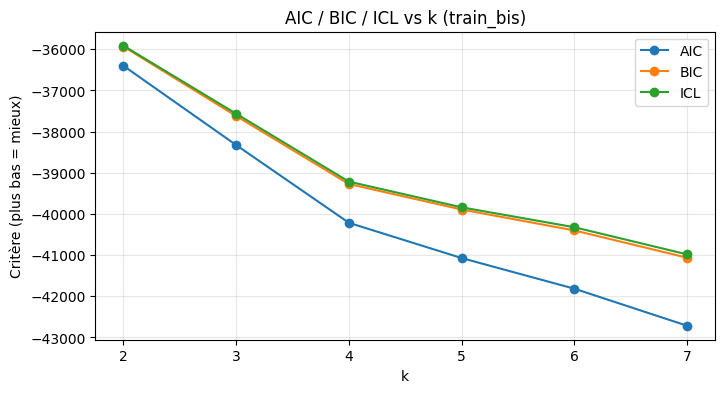


Extrait (train):
              p_regime_1    p_regime_2    p_regime_3    p_regime_4  \
sasdate                                                              
1962-07-01  1.190439e-06  5.793615e-04  9.290435e-12  4.062721e-06   
1962-08-01  6.257505e-09  8.985104e-03  4.329159e-14  2.212610e-04   
1962-09-01  5.541683e-07  2.535660e-08  2.288500e-16  6.958745e-10   
1962-10-01  3.990200e-09  2.656126e-07  2.129697e-15  1.241909e-07   
1962-11-01  2.049246e-09  1.020447e-07  5.288652e-18  9.351724e-09   

            p_regime_5     loglik  regime  
sasdate                                    
1962-07-01    0.999415  27.815177       5  
1962-08-01    0.990794  30.048095       5  
1962-09-01    0.999999  42.795300       5  
1962-10-01    1.000000  39.554151       5  
1962-11-01    1.000000  37.791607       5  

Extrait (test):
            p_regime_1    p_regime_2    p_regime_3    p_regime_4  \
sasdate                                                            
2016-01-01    1.000000  1.6920

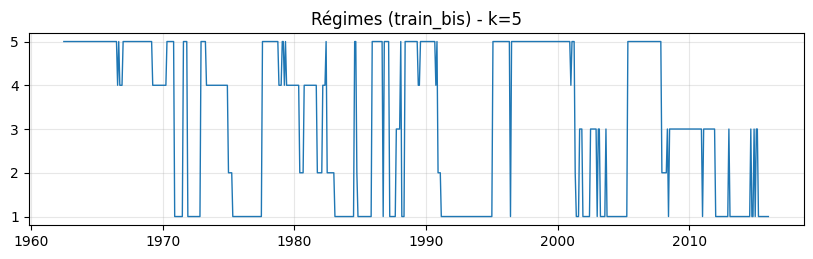

In [153]:
# ----------------------------
# 0) Données d'entrée (bis)
# ----------------------------
# Hypothèses : train_std_bis, test_std_bis existent déjà (DataFrames normalisés)
X_bis_train = fred_IS_bis.copy()
X_bis_test  = fred_OOS_bis.copy()

# (sécurité) enlève colonnes 100% NaN s'il y en a
keep_cols = X_bis_train.columns[X_bis_train.notna().any()]
X_bis_train = X_bis_train[keep_cols]
X_bis_test  = X_bis_test.reindex(columns=keep_cols)

# ----------------------------
# 1) Critères AIC/BIC/ICL pour k=2..9
# ----------------------------
k_candidates = range(2, 8)
rows = []
models = {}

for k_ in k_candidates:
    g = GaussianMixture(
        n_components=k_,
        covariance_type="diag",
        n_init=10,
        reg_covar=1e-6,
        random_state=42
    ).fit(X_bis_train)

    bic = g.bic(X_bis_train)
    aic = g.aic(X_bis_train)
    tau = np.clip(g.predict_proba(X_bis_train), 1e-12, 1.0)
    ent = (tau * np.log(tau)).sum()         # <= 0
    icl = bic - 2.0 * ent                   # ICL à minimiser

    rows.append({
        "k": k_,
        "loglik": g.lower_bound_,
        "AIC": aic, "BIC": bic, "ENT": ent, "ICL": icl
    })
    models[k_] = g

ic_df = pd.DataFrame(rows).set_index("k")
print("\n=== Critères par k (TRAIN bis) ===")
print(ic_df.sort_values("ICL"))

# (optionnel) visu
plt.figure(figsize=(8,4))
for col in ["AIC","BIC","ICL"]:
    plt.plot(ic_df.index, ic_df[col], marker='o', label=col)
plt.xlabel("k"); plt.ylabel("Critère (plus bas = mieux)")
plt.title("AIC / BIC / ICL vs k (train_bis)")
plt.grid(alpha=0.3); plt.legend(); plt.show()

# ----------------------------
# 2) Choix du nombre de régimes
# ----------------------------
# Option auto : décommente pour choisir k minimisant l'ICL
# chosen_k = ic_df["ICL"].idxmin()

# Ou fixe-le manuellement
chosen_k = 5

gmm = models[chosen_k]
if hasattr(gmm, "converged_") and not gmm.converged_:
    print("GMM non convergé.")

# ----------------------------
# 3) Prédictions train/test (bis)
# ----------------------------
labels_tr = gmm.predict(X_bis_train)         # 0..k-1
probas_tr = gmm.predict_proba(X_bis_train)
llk_tr    = gmm.score_samples(X_bis_train)

labels_te = gmm.predict(X_bis_test)
probas_te = gmm.predict_proba(X_bis_test)
llk_te    = gmm.score_samples(X_bis_test)

# ----------------------------
# 4) Séries indexées + régimes commençant à 1
# ----------------------------
gmm_labels_train = pd.Series(labels_tr + 1, index=X_bis_train.index,
                             name="regime").astype(int)
gmm_labels_test  = pd.Series(labels_te + 1, index=X_bis_test.index,
                             name="regime").astype(int)

# (facultatif) DataFrames de diagnostic
gmm_diag_train = pd.DataFrame(
    probas_tr, index=X_bis_train.index,
    columns=[f"p_regime_{i+1}" for i in range(chosen_k)]
).assign(loglik=llk_tr, regime=gmm_labels_train)

gmm_diag_test = pd.DataFrame(
    probas_te, index=X_bis_test.index,
    columns=[f"p_regime_{i+1}" for i in range(chosen_k)]
).assign(loglik=llk_te, regime=gmm_labels_test)

print("\nExtrait (train):")
print(gmm_diag_train.head())
print("\nExtrait (test):")
print(gmm_diag_test.head())

# ----------------------------
# 5) (optionnel) petite visu des régimes
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 2.5))
ax.plot(gmm_labels_train.index, gmm_labels_train.values, lw=1)
ax.set_title(f"Régimes (train_bis) - k={chosen_k}")
ax.set_yticks(range(1, chosen_k+1))
ax.grid(alpha=0.3)
plt.show()


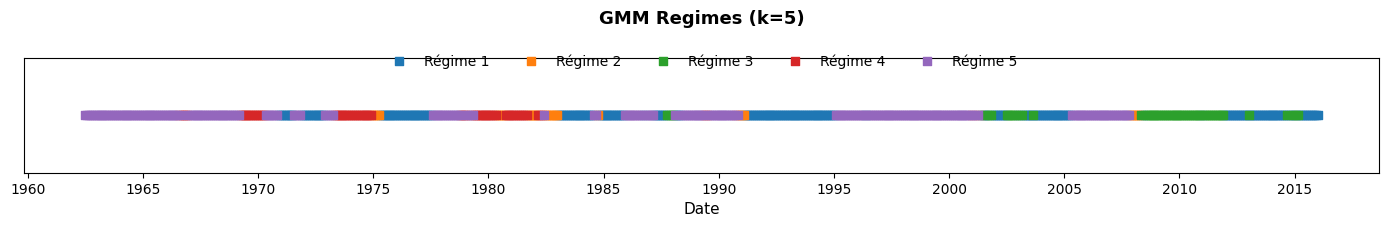

In [ ]:
# --- Données : labels et index temps ---
dates = gmm_labels_train.index
labels = gmm_labels_train

# --- Palette cohérente (commence à 1) ---
n_regimes = labels.max()
palette = sns.color_palette("tab10", n_colors=n_regimes)

# --- Figure principale ---
fig, ax = plt.subplots(figsize=(14, 2.5))

for k_ in range(1, n_regimes + 1):
    idx_k = labels[labels == k_].index
    ax.scatter(idx_k, [0]*len(idx_k), s=30, color=palette[k_-1],
               label=f"Régime {k_}", marker="s")

# --- Mise en forme ---
ax.set_yticks([])
ax.set_xlabel("Date", fontsize=11)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.grid(False)

ax.set_title(f"GMM Regimes (k={n_regimes})", fontsize=13, weight="bold", pad=25)

# --- Légende centrée et propre ---
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=n_regimes,
    frameon=False
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [155]:
# --- Entropie et pureté ---
tau = gmm.predict_proba(X_bis_train)
entropy = -(tau * np.log(tau + 1e-12)).sum(axis=1).mean()
purity = np.mean(tau.max(axis=1))
print(f"Entropie moyenne: {entropy:.4f}")
print(f"Pureté moyenne:   {purity:.4f}")

Entropie moyenne: 0.0415
Pureté moyenne:   0.9851


### K-means


=== Métriques K-Means (TRAIN bis) ===
        inertia  silhouette  calinski_harabasz  davies_bouldin
k                                                             
2  14890.685422    0.135852          78.660492        2.360945
3  13905.238464    0.110096          64.729828        2.602616
4  13269.358159    0.064496          55.357667        2.571231
5  12848.866520    0.064174          48.029668        2.530420
6  12490.559665    0.065377          43.118636        2.154880
7  12224.401850    0.053303          38.964803        2.486445


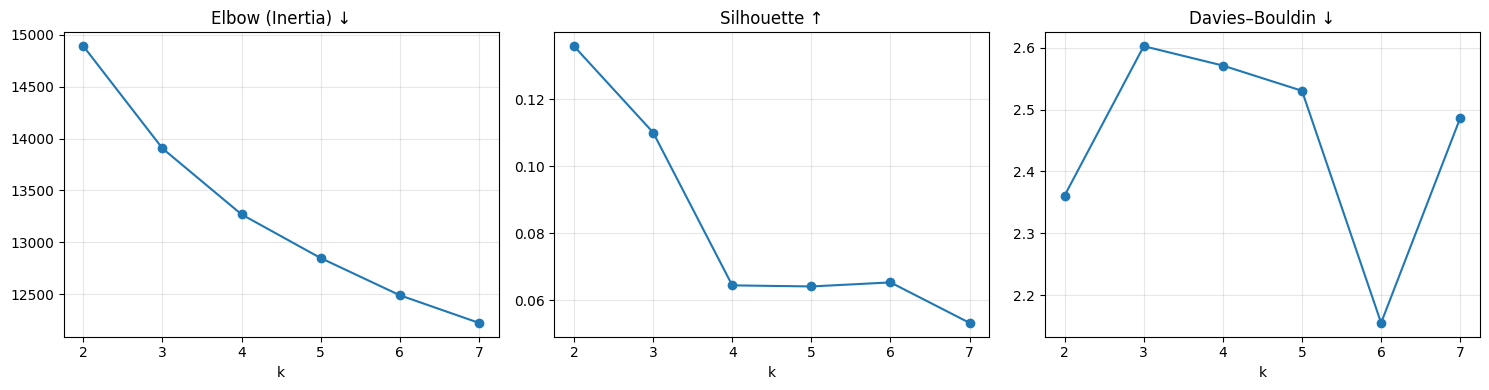


Choix final k = 2

Distribution des régimes (train) :
regime
1    179
2    464
Name: count, dtype: int64

Confiance (ratio d1/d2) — plus petit = assignation plus nette :
count    643.000000
mean       0.756371
std        0.137528
min        0.393268
25%        0.645314
50%        0.762340
75%        0.867669
max        0.998631
Name: margin, dtype: float64


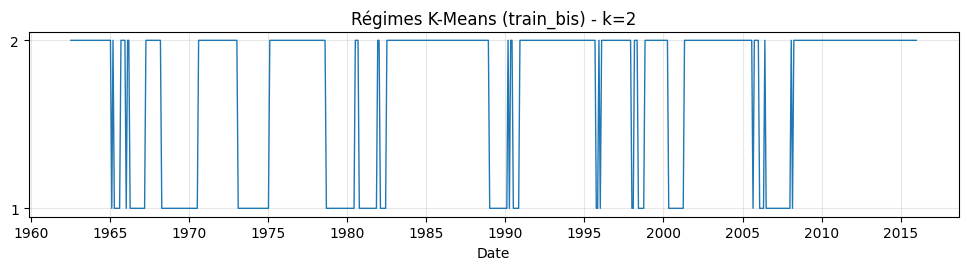

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# ----------------------------
# 0) Données d'entrée (bis)
# ----------------------------
# Hypothèse : train_std_bis, test_std_bis existent (DataFrames normalisés)
X_bis_train = train_std_bis.copy()
X_bis_test  = test_std_bis.copy()

# (sécurité) enlève colonnes 100% NaN s'il y en a
keep_cols = X_bis_train.columns[X_bis_train.notna().any()]
X_bis_train = X_bis_train[keep_cols]
X_bis_test  = X_bis_test.reindex(columns=keep_cols)

# ----------------------------
# 1) Grid search de k : métriques K-Means
# ----------------------------
k_candidates = range(2, 8)
rows = []
models = {}

for k_ in k_candidates:
    km = KMeans(
        n_clusters=k_,
        n_init=20,
        max_iter=500,
        random_state=42
    ).fit(X_bis_train)

    labels_tr = km.labels_
    inertia   = km.inertia_  # somme des distances au centre (within-cluster SSE)

    # certaines métriques nécessitent au moins 2 clusters et n_samples > k
    if len(X_bis_train) > k_:
        sil = silhouette_score(X_bis_train, labels_tr)
        ch  = calinski_harabasz_score(X_bis_train, labels_tr)
        db  = davies_bouldin_score(X_bis_train, labels_tr)
    else:
        sil, ch, db = np.nan, np.nan, np.nan

    rows.append({
        "k": k_,
        "inertia": inertia,       # à minimiser (elbow)
        "silhouette": sil,        # à maximiser
        "calinski_harabasz": ch,  # à maximiser
        "davies_bouldin": db      # à minimiser
    })
    models[k_] = km

km_df = pd.DataFrame(rows).set_index("k")
print("\n=== Métriques K-Means (TRAIN bis) ===")
print(km_df)

# (optionnel) visu des critères
fig, ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].plot(km_df.index, km_df["inertia"], marker='o'); ax[0].set_title("Elbow (Inertia) ↓"); ax[0].set_xlabel("k"); ax[0].grid(alpha=0.3)
ax[1].plot(km_df.index, km_df["silhouette"], marker='o'); ax[1].set_title("Silhouette ↑"); ax[1].set_xlabel("k"); ax[1].grid(alpha=0.3)
ax[2].plot(km_df.index, km_df["davies_bouldin"], marker='o'); ax[2].set_title("Davies–Bouldin ↓"); ax[2].set_xlabel("k"); ax[2].grid(alpha=0.3)
plt.tight_layout(); plt.show()

# ----------------------------
# 2) Choix du nombre de régimes
# ----------------------------
# Option auto (choix par silhouette, fallback DBI)
try:
    chosen_k = km_df["silhouette"].idxmax()
except Exception:
    chosen_k = km_df["davies_bouldin"].idxmin()

# Ou fixe-le manuellement :
# chosen_k = 5

kmeans = models[chosen_k]

# ----------------------------
# 3) Prédictions train/test (bis)
# ----------------------------
labels_tr = kmeans.predict(X_bis_train)   # 0..k-1
labels_te = kmeans.predict(X_bis_test)

# ----------------------------
# 4) Séries indexées + régimes commençant à 1
# ----------------------------
km_labels_train = pd.Series(labels_tr + 1, index=X_bis_train.index,
                            name="regime").astype(int)
km_labels_test  = pd.Series(labels_te + 1, index=X_bis_test.index,
                            name="regime").astype(int)

print(f"\nChoix final k = {chosen_k}")
print("\nDistribution des régimes (train) :")
print(km_labels_train.value_counts().sort_index())

# ----------------------------
# 5) (optionnel) "confiance" d’assignation
#    ratio = d1 / d2 avec d1 = distance au centre le plus proche,
#    d2 = distance au 2e plus proche (plus petit = plus net)
# ----------------------------
def assignment_margin(X, km):
    # distances aux centres (n_samples x k)
    # scikit-learn >=1.4 : km.transform(X) donne distances euclidiennes
    D = kmeans.transform(X)
    d_sorted = np.sort(D, axis=1)
    return (d_sorted[:, 0] / (d_sorted[:, 1] + 1e-12))

margin_train = pd.Series(assignment_margin(X_bis_train, kmeans),
                         index=X_bis_train.index, name="margin")
print("\nConfiance (ratio d1/d2) — plus petit = assignation plus nette :")
print(margin_train.describe())

# ----------------------------
# 6) (optionnel) timeline des régimes (train)
# ----------------------------
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12, 2.4))
ax.plot(km_labels_train.index, km_labels_train.values, lw=1)
ax.set_title(f"Régimes K-Means (train_bis) - k={chosen_k}")
ax.set_yticks(range(1, chosen_k+1))
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.grid(alpha=0.3)
plt.show()


Étape 1 : Détection des outliers via One-Class SVM (sur PCA)...
Outliers détectés (OCSVM) : 67 sur 643 observations (10.4%).
Étape 2 : K-means cosinus sur les mois typiques (PCA)...


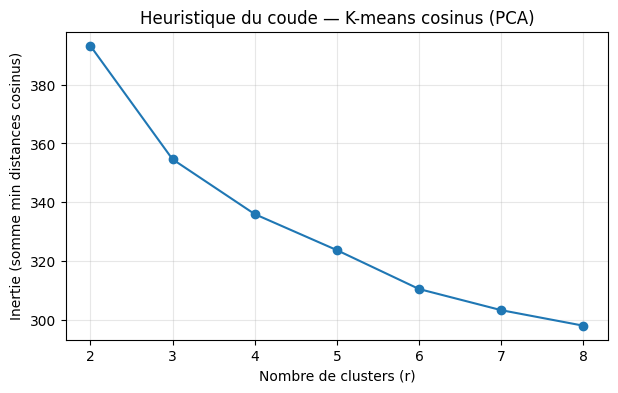

Nombre de régimes réguliers retenu : r = 5
Clustering cosinus terminé.
Étape 3 : Calcul des distributions de probabilité...
Étape 4 : Calcul de la matrice de transition...
Matrice de transition P(i→j) :
       0      1      2      3      4      5
0  0.388  0.224  0.045  0.134  0.164  0.045
1  0.136  0.515  0.098  0.076  0.045  0.129
2  0.035  0.105  0.442  0.198  0.012  0.209
3  0.042  0.084  0.126  0.587  0.018  0.144
4  0.083  0.065  0.009  0.019  0.806  0.019
5  0.049  0.232  0.122  0.366  0.012  0.220


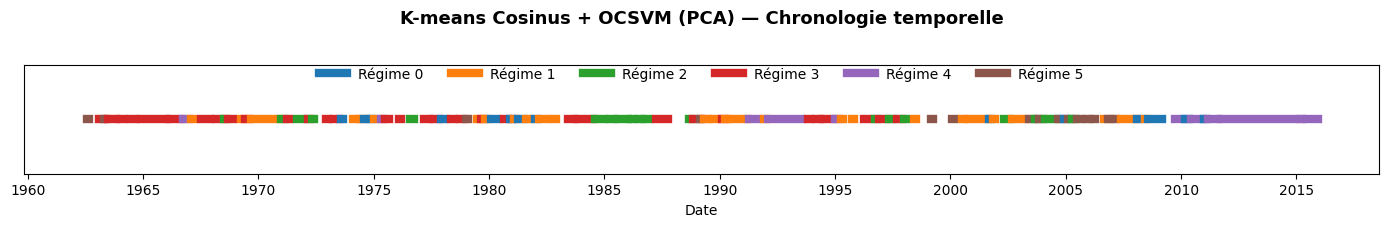

In [ ]:
# ============================================
# K-MEANS REGIME DETECTION — VERSION PCA + OCSVM (FIDÈLE AUTEURS)
# ============================================

# ----------------------------------------------------
# 1. Détection des outliers via One-Class SVM
# ----------------------------------------------------
print("Étape 1 : Détection des outliers via One-Class SVM (sur PCA)...")

# ν = fraction maximale d'outliers (ex: 0.02 = 2%)
ocs = OneClassSVM(kernel="rbf", nu=0.1, gamma="scale").fit(fred_PCA_IS)
is_outlier = ocs.predict(fred_PCA_IS) == -1
decision_scores = ocs.decision_function(fred_PCA_IS)  # plus petit = plus anormal

# Convertir scores en probabilité approchée (sigmoïde)
from scipy.special import expit
p_reg0 = 1 - expit((decision_scores - np.min(decision_scores)) / (np.std(decision_scores) + 1e-8))

X_typical = fred_PCA_IS.loc[~is_outlier]
dates_typical = X_typical.index
print(f"Outliers détectés (OCSVM) : {is_outlier.sum()} sur {len(fred_PCA_IS)} observations ({100*is_outlier.mean():.1f}%).")

# ----------------------------------------------------
# 2. Vrai K-means Cosinus sur les mois typiques
# ----------------------------------------------------
print("Étape 2 : K-means cosinus sur les mois typiques (PCA)...")

def spherical_kmeans(X, k, max_iter=300, tol=1e-6, random_state=42):
    rng = np.random.default_rng(random_state)
    X = normalize(X, norm='l2')  # chaque observation sur la sphère unité
    n, d = X.shape

    centers = X[rng.choice(n, k, replace=False)]
    centers = normalize(centers, norm='l2')

    for it in range(max_iter):
        sim = X @ centers.T
        labels = np.argmax(sim, axis=1)
        new_centers = np.zeros_like(centers)
        for j in range(k):
            cluster_points = X[labels == j]
            if len(cluster_points) > 0:
                new_centers[j] = normalize(cluster_points.mean(axis=0).reshape(1, -1))
            else:
                new_centers[j] = centers[j]
        diff = np.linalg.norm(new_centers - centers)
        centers = new_centers
        if diff < tol:
            break
    dist_cos = 1 - (X @ centers.T)
    return labels, centers, dist_cos

# --- Détermination du nombre optimal r
inertias = []
k_range = range(2, 9)
X_typical_np = X_typical.values
for k_ in k_range:
    labels, centers, dist_cos = spherical_kmeans(X_typical_np, k_)
    inertia = np.sum(np.min(dist_cos, axis=1))
    inertias.append(inertia)

plt.figure(figsize=(7, 4))
plt.plot(k_range, inertias, marker='o')
plt.title("Heuristique du coude — K-means cosinus (PCA)")
plt.xlabel("Nombre de clusters (r)")
plt.ylabel("Inertie (somme min distances cosinus)")
plt.grid(True, alpha=0.3)
plt.show()

r = 5  # ajuster selon le coude
print(f"Nombre de régimes réguliers retenu : r = {r}")

cos_labels, cos_centers, cos_dists = spherical_kmeans(X_typical_np, r)
print("Clustering cosinus terminé.")

# ----------------------------------------------------
# 3. Distributions de probabilité (Éqs. 1 et 4)
# ----------------------------------------------------
print("Étape 3 : Calcul des distributions de probabilité...")

cos_probs = 1 - (cos_dists / cos_dists.sum(axis=1, keepdims=True))
cos_probs = cos_probs / cos_probs.sum(axis=1, keepdims=True)

final_probs = pd.DataFrame(index=dates, columns=[f"Regime_{i}" for i in range(r+1)], dtype=float)
final_probs.loc[:, :] = 0.0

Pm = np.max(cos_probs, axis=1)
P0 = p_reg0[~is_outlier]

# Éq. (4) : P_R0 = - Pm * log2(1 - P(Regime 0))
PR0 = -Pm * np.log2(1 - P0)
PR0[np.isnan(PR0)] = 0.0
PR0[PR0 < 0] = 0.0

final_probs.loc[dates_typical, "Regime_0"] = PR0
for j in range(r):
    final_probs.loc[dates_typical, f"Regime_{j+1}"] = cos_probs[:, j]

final_probs.loc[dates[is_outlier], "Regime_0"] = 1.0
final_probs = final_probs.div(final_probs.sum(axis=1), axis=0)

hard_labels = final_probs.idxmax(axis=1).str.extract("(\d+)").astype(int).values.flatten()

# ----------------------------------------------------
# 4. Matrice de transition (Éq. 5)
# ----------------------------------------------------
print("Étape 4 : Calcul de la matrice de transition...")

ordered_labels = pd.Series(hard_labels, index=dates).sort_index()
regimes = np.unique(hard_labels)
transition_matrix = pd.DataFrame(0.0, index=regimes, columns=regimes)

for i in range(len(ordered_labels)-1):
    i_reg = ordered_labels.iloc[i]
    j_reg = ordered_labels.iloc[i+1]
    transition_matrix.loc[i_reg, j_reg] += 1

transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0).fillna(0)
print("Matrice de transition P(i→j) :")
print(transition_matrix.round(3))

# ----------------------------------------------------
# 5. Visualisation temporelle
# ----------------------------------------------------
# --- Nettoyage et paramétrage ---
res_kmeans = pd.DataFrame({"kmeans_label": hard_labels}, index=dates).sort_index()
palette = sns.color_palette("tab10", n_colors=res_kmeans["kmeans_label"].nunique())

fig, ax = plt.subplots(figsize=(14, 2.5))
ax.set_title("K-means Cosinus + OCSVM (PCA) — Chronologie temporelle", fontsize=13, weight="bold", pad=30)

# --- Construction de segments (blocs continus) ---
labels = res_kmeans["kmeans_label"].values
times = res_kmeans.index

start_idx = 0
for i in range(1, len(labels)):
    if labels[i] != labels[i-1] or i == len(labels)-1:
        ax.plot(times[start_idx:i], [0]* (i-start_idx),
                color=palette[labels[i-1]], lw=6)
        start_idx = i

# --- Mise en forme ---
ax.set_yticks([])
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax.legend(
    handles=[plt.Line2D([0], [0], color=palette[k], lw=6, label=f"Régime {k}")
             for k in sorted(res_kmeans["kmeans_label"].unique())],
    loc="upper center",
    bbox_to_anchor=(0.5, 1.10),
    ncol=res_kmeans["kmeans_label"].nunique(),
    frameon=False
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Étape 1 : Détection des outliers via One-Class SVM (sur TRAIN)...
Outliers détectés (TRAIN) : 69 / 643 (10.7%).
Étape 2 : K-Means cosinus (sans PCA) sur les mois typiques...


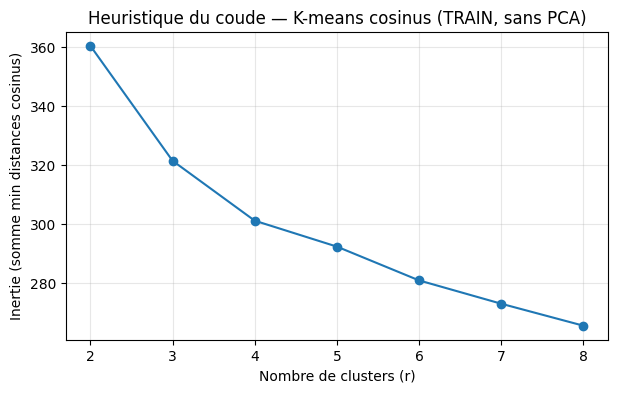

Nombre de régimes réguliers retenu : r = 5
Clustering cosinus (TRAIN) terminé.
Étape 3 : Calcul des distributions de probabilité (TRAIN)...
Étape 4 : Matrice de transition (TRAIN)...
Matrice de transition P(i→j) — TRAIN :
       0      1      2      3      4      5
0  0.426  0.132  0.044  0.162  0.147  0.088
1  0.135  0.674  0.022  0.146  0.000  0.022
2  0.025  0.008  0.542  0.068  0.305  0.051
3  0.074  0.221  0.103  0.368  0.000  0.235
4  0.094  0.014  0.201  0.014  0.662  0.014
5  0.044  0.012  0.081  0.056  0.006  0.800


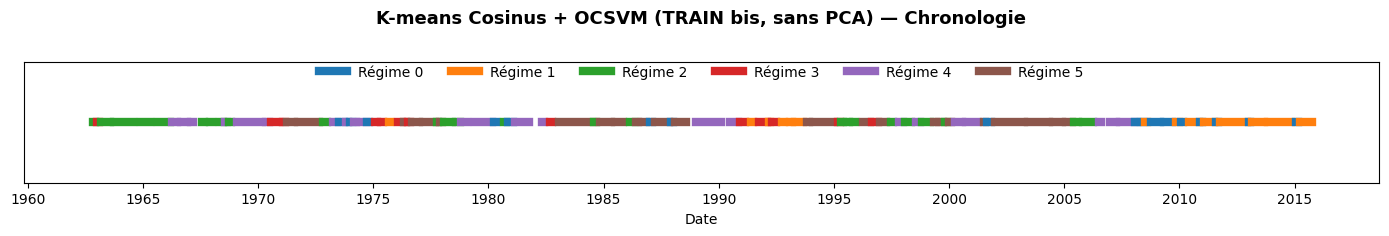

Projection sur TEST (mêmes OCSVM/centres)...
Distribution des régimes (TEST) :
kmeans_label
0    24
1    18
2    23
3     7
4    32
5    12
Name: count, dtype: int64


In [ ]:

# =========================================================
# 0) Données d'entrée (déjà normalisées avec moments du train)
# =========================================================
# Hypothèses : train_std_bis, test_std_bis existent déjà
X_tr = train_std_bis.copy()
X_te = test_std_bis.copy()

# Sécurité colonnes vides / alignement
keep_cols = X_tr.columns[X_tr.notna().any()]
X_tr = X_tr[keep_cols]
X_te = X_te.reindex(columns=keep_cols)

dates_tr = X_tr.index
dates_te = X_te.index

# =========================================================
# 1) OCSVM — détection des outliers (fit uniquement sur TRAIN)
# =========================================================
print("Étape 1 : Détection des outliers via One-Class SVM (sur TRAIN)...")

ocs = OneClassSVM(kernel="rbf", nu=0.10, gamma="scale").fit(X_tr)
is_outlier_tr = (ocs.predict(X_tr) == -1)
decision_scores_tr = ocs.decision_function(X_tr)   # plus petit = plus anormal

# Calibration heuristique proba outlier (stable train->test)
p_reg0_tr = 1 - expit((decision_scores_tr - decision_scores_tr.min()) /
                       (decision_scores_tr.std() + 1e-8))

X_typ_tr = X_tr.loc[~is_outlier_tr]
dates_typ_tr = X_typ_tr.index

print(f"Outliers détectés (TRAIN) : {is_outlier_tr.sum()} / {len(X_tr)} "
      f"({100*is_outlier_tr.mean():.1f}%).")

# =========================================================
# 2) Spherical K-Means (cosinus) sur mois typiques (TRAIN)
# =========================================================
print("Étape 2 : K-Means cosinus (sans PCA) sur les mois typiques...")

def spherical_kmeans(X, k, max_iter=300, tol=1e-6, random_state=42):
    rng = np.random.default_rng(random_state)
    Xn = normalize(X, norm='l2')   # cosinus <=> points sur la sphère
    n, d = Xn.shape

    centers = Xn[rng.choice(n, k, replace=False)]
    centers = normalize(centers, norm='l2')

    for _ in range(max_iter):
        sim = Xn @ centers.T                    # similarité cosinus
        labels = np.argmax(sim, axis=1)
        new_centers = np.zeros_like(centers)
        for j in range(k):
            pts = Xn[labels == j]
            new_centers[j] = normalize(pts.mean(axis=0, keepdims=True)) if len(pts) else centers[j]
        diff = np.linalg.norm(new_centers - centers)
        centers = new_centers
        if diff < tol:
            break

    dist_cos = 1 - (Xn @ centers.T)            # distance cosinus = 1 - cos
    return labels, centers, dist_cos

# Heuristique du coude pour choisir r
inertias, k_range = [], range(2, 9)
X_typ_np = X_typ_tr.values
for k_ in k_range:
    _, _, dist_cos = spherical_kmeans(X_typ_np, k_)
    inertias.append(np.sum(np.min(dist_cos, axis=1)))

plt.figure(figsize=(7, 4))
plt.plot(k_range, inertias, marker='o')
plt.title("Heuristique du coude — K-means cosinus (TRAIN, sans PCA)")
plt.xlabel("Nombre de clusters (r)")
plt.ylabel("Inertie (somme min distances cosinus)")
plt.grid(True, alpha=0.3)
plt.show()

r = 5  # <-- ajuste selon le coude
print(f"Nombre de régimes réguliers retenu : r = {r}")

cos_labels_tr, cos_centers, cos_dists_tr = spherical_kmeans(X_typ_np, r)
print("Clustering cosinus (TRAIN) terminé.")

# =========================================================
# 3) Distributions de probabilité — TRAIN
#    (Régime_0 = outliers ; Régimes 1..r = clusters cosinus)
# =========================================================
print("Étape 3 : Calcul des distributions de probabilité (TRAIN)...")

cos_probs_tr = 1 - (cos_dists_tr / cos_dists_tr.sum(axis=1, keepdims=True))
cos_probs_tr = cos_probs_tr / cos_probs_tr.sum(axis=1, keepdims=True)

final_probs_tr = pd.DataFrame(index=dates_tr, columns=[f"Regime_{i}" for i in range(r+1)], dtype=float)
final_probs_tr.loc[:, :] = 0.0

Pm_tr = np.max(cos_probs_tr, axis=1)
P0_tr = p_reg0_tr[~is_outlier_tr]

PR0_tr = -Pm_tr * np.log2(1 - P0_tr)
PR0_tr = np.nan_to_num(PR0_tr, nan=0.0)
PR0_tr[PR0_tr < 0] = 0.0

final_probs_tr.loc[dates_typ_tr, "Regime_0"] = PR0_tr
for j in range(r):
    final_probs_tr.loc[dates_typ_tr, f"Regime_{j+1}"] = cos_probs_tr[:, j]

# Outliers purs
final_probs_tr.loc[dates_tr[is_outlier_tr], "Regime_0"] = 1.0
final_probs_tr = final_probs_tr.div(final_probs_tr.sum(axis=1), axis=0)

hard_labels_tr = final_probs_tr.idxmax(axis=1).str.extract(r"(\d+)").astype(int).values.flatten()
res_kmeans_tr = pd.DataFrame({"kmeans_label": hard_labels_tr}, index=dates_tr).sort_index()

# =========================================================
# 4) Matrice de transition — TRAIN
# =========================================================
print("Étape 4 : Matrice de transition (TRAIN)...")

lbl_tr = res_kmeans_tr["kmeans_label"].values
regimes_tr = np.unique(lbl_tr)
T_tr = pd.DataFrame(0.0, index=regimes_tr, columns=regimes_tr)

for a, b in zip(lbl_tr[:-1], lbl_tr[1:]):
    T_tr.loc[a, b] += 1.0

T_tr = T_tr.div(T_tr.sum(axis=1), axis=0).fillna(0.0)
print("Matrice de transition P(i→j) — TRAIN :")
print(T_tr.round(3))

# =========================================================
# 5) Visualisation — TRAIN
# =========================================================
palette = sns.color_palette("tab10", n_colors=len(np.unique(lbl_tr)))

fig, ax = plt.subplots(figsize=(14, 2.6))
ax.set_title("K-means Cosinus + OCSVM (TRAIN bis, sans PCA) — Chronologie", fontsize=13, weight="bold", pad=28)

times = res_kmeans_tr.index.to_numpy()
start = 0
for i in range(1, len(lbl_tr)):
    if lbl_tr[i] != lbl_tr[i-1]:
        ax.plot(times[start:i], [0]*(i-start), color=palette[lbl_tr[i-1] % len(palette)], lw=6)
        start = i
ax.plot(times[start:], [0]*(len(lbl_tr)-start), color=palette[lbl_tr[-1] % len(palette)], lw=6)

ax.set_yticks([])
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.legend(
    handles=[plt.Line2D([0], [0], color=palette[k % len(palette)], lw=6, label=f"Régime {k}")
             for k in sorted(np.unique(lbl_tr))],
    loc="upper center", bbox_to_anchor=(0.5, 1.08),
    ncol=min(len(np.unique(lbl_tr)), 8), frameon=False
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
# ----------------------------
# Projection sur TEST (mêmes OCSVM/centres) — FIX broadcast
# ----------------------------
print("Projection sur TEST (mêmes OCSVM/centres)...")

# 1) Outliers test avec le même OCSVM
is_outlier_te = (ocs.predict(X_te) == -1)                         # shape (n_test,)
decision_scores_te = ocs.decision_function(X_te)

# même calibration (échelle train)
p_reg0_te = 1 - expit((decision_scores_te - decision_scores_tr.min()) /
                       (decision_scores_tr.std() + 1e-8))

# 2) Distances cosinus test → centres appris sur TRAIN
Xn_te = normalize(X_te.values, norm='l2')
cos_dists_te = 1 - (Xn_te @ cos_centers.T)                         # (n_test, r)
cos_probs_te = 1 - (cos_dists_te / cos_dists_te.sum(axis=1, keepdims=True))
cos_probs_te = cos_probs_te / cos_probs_te.sum(axis=1, keepdims=True)

# 3) Conteneur des probabilités (Regime_0..Regime_r)
final_probs_te = pd.DataFrame(
    0.0, index=dates_te, columns=[f"Regime_{i}" for i in range(r+1)]
)

# 4) Masques et index utiles
mask_nonout = ~is_outlier_te
idx_nonout  = dates_te[mask_nonout]
idx_out     = dates_te[is_outlier_te]

# 5) Remplissage cohérent des lignes non-outliers
Pm_te  = np.max(cos_probs_te, axis=1)
PR0_te = -Pm_te * np.log2(1 - p_reg0_te)
PR0_te = np.nan_to_num(PR0_te, nan=0.0)
PR0_te[PR0_te < 0] = 0.0

# Regime_0 pour non-outliers
final_probs_te.loc[idx_nonout, "Regime_0"] = PR0_te[mask_nonout]

# Regime_1..Regime_r pour non-outliers (🔥 FIX ICI)
for j in range(r):
    final_probs_te.loc[idx_nonout, f"Regime_{j+1}"] = cos_probs_te[mask_nonout, j]

# 6) Lignes outliers purs
final_probs_te.loc[idx_out, :] = 0.0
final_probs_te.loc[idx_out, "Regime_0"] = 1.0

# 7) Normalisation ligne (sécurité numérique)
row_sums = final_probs_te.sum(axis=1)
final_probs_te = final_probs_te.div(row_sums.replace(0.0, 1.0), axis=0)

# 8) Labels durs 0..r (0 = outlier)
hard_labels_te = final_probs_te.idxmax(axis=1).str.extract(r"(\d+)").astype(int).values.flatten()
res_kmeans_te  = pd.DataFrame({"kmeans_label": hard_labels_te}, index=dates_te).sort_index()

print("Distribution des régimes (TEST) :")
print(res_kmeans_te["kmeans_label"].value_counts().sort_index())

# (option) sanity checksdd
assert np.allclose(final_probs_te.sum(axis=1).values, 1.0, atol=1e-8), "Les lignes ne somment pas à 1."


### Summary of Useful Series:

reg_gmm_IS

reg_gmm_IS_bis


reg_kmeans_IS — in-sample Series of regime labels from k-means (training targets).

reg_kmeans_logreg_OOS — out-of-sample Series of predicted regime labels from logistic regression.

fred_PCA_IS — In-sample PCA of standardized FRED data (PCA fitted on fred_IS_std).

fred_PCA_OOS — Out-of-sample projection onto the IS PCA components (pca.transform).

fred_PCA — Combined IS + OOS PCA dataset in the same PCA space.

## Predicting Market Regimes

In [176]:
# ---------------------------
# 1) Construire X,y (IS) pour prédire regime_{t+1}
# ---------------------------
# gmm_labels : Series (index = dates_train), labels sur TRAIN (à t)
# On veut y_t = label_{t+1}
y_train = gmm_labels.shift(-1).dropna().astype(int)

# Aligner X sur y (même index)
X_train_super = fred_PCA_IS.loc[y_train.index]

# Sanity check dimensions
assert len(X_train_super) == len(y_train)

tscv = TimeSeriesSplit(n_splits=5)
best_C, best_score = None, -np.inf
# ---------------------------
# 2) Validation temporelle simple (expanding split)
# ---------------------------

for C in [0.1, 0.5, 1.0, 2.0, 5.0]:
    scores = []
    for tr_idx, va_idx in tscv.split(X_train_super):
        Xtr, Xva = X_train_super.iloc[tr_idx], X_train_super.iloc[va_idx]
        ytr, yva = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        clf = LogisticRegression(
            multi_class="multinomial",
            solver="lbfgs",
            C=C,
            class_weight="balanced",
            max_iter=200
        )
        clf.fit(Xtr, ytr)
        pva = clf.predict_proba(Xva)

        # garder seulement les points de validation dont la classe est connue du modèle
        mask = yva.isin(clf.classes_)
        if mask.sum() == 0:
            continue  # aucun point évaluable dans ce split

        yva_f = yva[mask]
        pva_f = pva[mask.values, :]  # aligner les proba sur les indices valides

        score = -log_loss(yva_f, pva_f, labels=clf.classes_)
        scores.append(score)

    # moyenne sur les splits
    if len(scores) > 0:
        mean_score = np.mean(scores)
        if mean_score > best_score:
            best_score, best_C = mean_score, C

print(f"Meilleur C (CV): {best_C:.2f}  |  score CV (−logloss): {best_score:.4f}")

# ---------------------------
# 3) Fit final sur tout l'IS avec le meilleur C
# ---------------------------
clf = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    C=best_C,
    class_weight="balanced",
    max_iter=500
)
clf.fit(X_train_super, y_train)

# (diagnostics IS)
yhat_is = clf.predict(X_train_super)
p_is = clf.predict_proba(X_train_super)
print("Balanced Acc (IS):", balanced_accuracy_score(y_train, yhat_is))
print("Macro-F1 (IS):", f1_score(y_train, yhat_is, average="macro"))

# ---------------------------
# 4) Inférence OOS (t -> t+1) sur X_pca_test
# ---------------------------
# Attention: on ne connaît pas y_test (pas de labels OOS) → on sort des PROBAS
p_test = pd.DataFrame(
    clf.predict_proba(X_pca_test),
    index=X_pca_test.index,
    columns=[f"reg_{k}" for k in clf.classes_]
)

# label "dur" (si tu veux visualiser) = argmax
yhat_oos_hard = p_test.values.argmax(axis=1)
yhat_oos_hard = pd.Series(yhat_oos_hard, index=p_test.index, name="regime_pred_hard")

# ---------------------------
# 5) (Option) Hystérésis / persistance minimale sur les probas
# ---------------------------
def apply_hysteresis(prob_df, enter=0.65, exit_=0.55, min_len=3):
    classes = prob_df.columns
    state_series = []
    cur_state, run_len = None, 0

    for t, row in prob_df.iterrows():
        pmax = row.max()
        smax = row.idxmax()  # string 'reg_k'
        kmax = int(smax.split("_")[-1])

        if cur_state is None:
            # entrer si assez confiant
            cur_state = kmax if pmax >= enter else kmax  # ou None si tu veux du 'no-position'
            run_len = 1
        else:
            if kmax == cur_state:
                run_len += 1
            else:
                # quitter seulement si perte de confiance + durée min atteinte
                if (pmax >= enter) and (run_len >= min_len):
                    cur_state = kmax
                    run_len = 1
                elif (row[f"reg_{cur_state}"] < exit_) and (run_len >= min_len):
                    cur_state = kmax
                    run_len = 1
                else:
                    run_len += 1  # maintenir

        state_series.append(cur_state)

    return pd.Series(state_series, index=prob_df.index, name="regime_pred_smooth")

yhat_oos_smooth = apply_hysteresis(p_test, enter=0.65, exit_=0.55, min_len=3)

# ---------------------------
# 6) (Option) Mapping économique des états
# ---------------------------
# Si tu as défini sur IS un mapping 'éco' (ex: crise=vol SPX max), applique-le ici
# map_dict = {old_label: new_label}  # ex: {2:1, 0:0, 3:2, ...}
# yhat_oos_smooth = yhat_oos_smooth.map(map_dict)

# ---------------------------
# 7) (Option) Sauvegarde des sorties pour backtest
# ---------------------------
supervised_out = pd.concat([p_test, yhat_oos_hard, yhat_oos_smooth], axis=1)
print(supervised_out.head())


c:\Users\user\anaconda3\envs\anto\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\user\anaconda3\envs\anto\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\user\anaconda3\envs\anto\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\user\anaconda3\envs\anto\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'm

Meilleur C (CV): 0.10  |  score CV (−logloss): -1.8759
Balanced Acc (IS): 0.7361787442295916
Macro-F1 (IS): 0.6679254755201348
               reg_0     reg_1     reg_2     reg_3     reg_4     reg_5  \
sasdate                                                                  
2016-01-01  0.008147  0.035271  0.869758  0.016072  0.054594  0.016158   
2016-02-01  0.562281  0.275131  0.007877  0.078637  0.033178  0.042896   
2016-03-01  0.022416  0.160906  0.752192  0.017277  0.039405  0.007804   
2016-04-01  0.159113  0.328935  0.338368  0.132040  0.033295  0.008248   
2016-05-01  0.046580  0.119988  0.784496  0.018426  0.008421  0.022089   

            regime_pred_hard  regime_pred_smooth  
sasdate                                           
2016-01-01                 2                   2  
2016-02-01                 0                   2  
2016-03-01                 2                   2  
2016-04-01                 2                   2  
2016-05-01                 2                   2

c:\Users\user\anaconda3\envs\anto\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\user\anaconda3\envs\anto\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


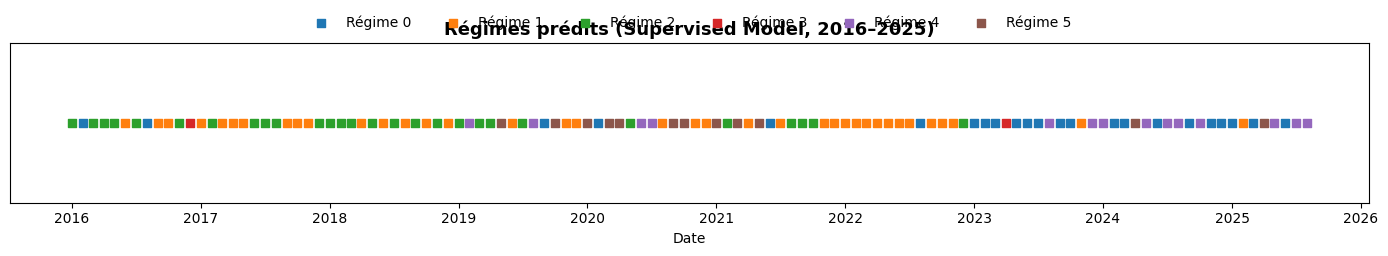

In [160]:
# ------------------------------------------------------------
reg_cols = [c for c in supervised_out.columns if c.startswith("reg_")]

gmm_labels_oos = (
    supervised_out.loc["2016-01-01":, reg_cols]
    .idxmax(axis=1)
    .str.extract(r"(\d+)").astype(int)[0]
    .rename("regime_pred")
)

dates_oos = gmm_labels_oos.index
n_regimes = gmm_labels_oos.max() + 1

# ------------------------------------------------------------
# 2) Palette + Figure
# ------------------------------------------------------------
palette = sns.color_palette("tab10", n_colors=n_regimes)

fig, ax = plt.subplots(figsize=(14, 2.8))
ax.set_title(f"Régimes prédits (Supervised Model, 2016–{dates_oos[-1].year})",
             fontsize=13, weight="bold")

# Timeline colorée (même style que GMM)
for k_ in range(n_regimes):
    idx_k = gmm_labels_oos[gmm_labels_oos == k_].index
    ax.scatter(idx_k, [0]*len(idx_k),
               s=35, color=palette[k_],
               label=f"Régime {k_}", marker="s")

# ------------------------------------------------------------
# 3) Mise en forme
# ------------------------------------------------------------
ax.set_yticks([])
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.grid(False)

ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.25),
    ncol=min(6, n_regimes),
    frameon=False
)

plt.tight_layout()
plt.show()


In [161]:
print(gmm_labels_oos)

sasdate
2016-01-01    2
2016-02-01    0
2016-03-01    2
2016-04-01    2
2016-05-01    2
             ..
2025-04-01    5
2025-05-01    4
2025-06-01    0
2025-07-01    4
2025-08-01    4
Name: regime_pred, Length: 116, dtype: int64


## Portfolio Implementation

Comme les facteurs commencent en 1963 on passe tout en 63

In [162]:

reg_kmeans_IS = res_kmeans.squeeze().copy()
reg_kmeans_logreg_OOS = gmm_labels_oos.copy()

indus_IS = indus_all.loc["1963-07-01":].copy()

res_kmeans = res_kmeans.loc["1963-07-01":].copy()



### Calcul des moments conditionnels

In [163]:
def conditional_moments(
    returns_df: pd.DataFrame,
    regimes_df: pd.DataFrame,
    label_col: str = "kmeans_label",
    cols: list[str] | None = None,
    min_obs: int = 12,
) -> tuple[pd.DataFrame, pd.DataFrame, dict[int, pd.DataFrame], pd.Series]:
    """
    Calcule E[R | régime], Std[R | régime], Cov[R | régime] avec alignement robuste des dates.
    
    Params
    ------
    returns_df : DataFrame
        Rendements (en proportions) indexés par Date.
    regimes_df : DataFrame
        Doit contenir une colonne `label_col` indexée par Date (mêmes unités temporelles).
    label_col : str
        Nom de la colonne contenant le label de régime.
    cols : list[str] | None
        Sous-ensemble de colonnes de returns à utiliser. Si None -> colonnes numériques.
    min_obs : int
        Nombre minimal d'observations par régime (sinon le régime est ignoré).

    Returns
    -------
    mean_df : DataFrame     # moyennes conditionnelles par régime
    std_df  : DataFrame     # écarts-types conditionnels par régime
    covs    : dict[int, DataFrame]  # matrices de covariance par régime
    n_by_regime : Series    # effectif par régime (après filtre)
    """

    # 1) Alignement des dates (intersection) en démarrant à la date commune la plus récente
    r0, g0 = returns_df.sort_index(), regimes_df.sort_index()
    start = max(r0.index.min(), g0.index.min())
    r1 = r0.loc[start:]
    g1 = g0.loc[start:]
    df = r1.join(g1[[label_col]], how="inner").dropna(subset=[label_col])

    # 2) Colonnes à utiliser
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.drop(label_col, errors="ignore")
    else:
        cols = pd.Index(cols).intersection(df.columns)

    # 3) Groupby et moments
    groups = dict(tuple(df.groupby(label_col)))
    means, stds, covs, counts = {}, {}, {}, {}
    for reg, sub in groups.items():
        subX = sub[cols].dropna(how="any")
        n = len(subX)
        if n >= min_obs:
            means[reg] = subX.mean()
            stds[reg]  = subX.std(ddof=1)
            covs[reg]  = subX.cov()
            counts[reg]= n

    # 4) Assemblage
    mean_df = pd.DataFrame(means).T.sort_index()
    std_df  = pd.DataFrame(stds).T.sort_index()
    n_by_regime = pd.Series(counts).sort_index()

    return mean_df, std_df, covs, n_by_regime


**Calcul moment conditionnel industries**

In [164]:
# Vérification de l'alignement temporel
print("Période industries :", indus_IS.index.min(), "→", indus_IS.index.max())
print("Période régimes   :", res_kmeans.index.min(), "→", res_kmeans.index.max())

# Appel de la fonction généralisée
mean_ind_IS, std_ind_IS, cov_ind_IS, n_ind_IS = conditional_moments(
    returns_df = indus_IS,     # rendements bruts industries
    regimes_df = res_kmeans,    # régimes K-means in-sample
    label_col  = "kmeans_label",
    min_obs    = 12
)

# Aperçu des résultats
print("=== Moyennes conditionnelles par régime ===")
print(mean_ind_IS.round(4))
print("\n=== Volatilités conditionnelles ===")
print(std_ind_IS.round(4))
print("\n=== Effectif par régime ===")
print(n_ind_IS)

# Exemple : covariance du régime 0
print("\n=== Covariance régime 0 ===")
print(cov_ind_IS[0].round(4))

print(mean_ind_IS.head())


Période industries : 1963-07-01 00:00:00 → 2025-09-01 00:00:00
Période régimes   : 1963-07-01 00:00:00 → 2016-01-01 00:00:00
=== Moyennes conditionnelles par régime ===
    NoDur   Durbl   Manuf   Enrgy   Chems   BusEq   Telcm   Utils   Shops  \
0  0.0046 -0.0069 -0.0045 -0.0062  0.0023  0.0021  0.0068 -0.0003  0.0043   
1  0.0155  0.0091  0.0103  0.0071  0.0110  0.0057  0.0074  0.0101  0.0159   
2  0.0216  0.0193  0.0197  0.0186  0.0212  0.0239  0.0182  0.0172  0.0233   
3  0.0028  0.0008  0.0032  0.0048  0.0016  0.0039 -0.0004  0.0003 -0.0013   
4  0.0133  0.0200  0.0145  0.0084  0.0121  0.0148  0.0152  0.0143  0.0154   
5  0.0098  0.0068  0.0166  0.0329  0.0096  0.0125  0.0111  0.0106  0.0089   

     Hlth   Money   Other  
0  0.0040 -0.0056 -0.0029  
1  0.0159  0.0125  0.0103  
2  0.0201  0.0250  0.0192  
3  0.0061  0.0001  0.0005  
4  0.0113  0.0162  0.0134  
5  0.0057  0.0099  0.0098  

=== Volatilités conditionnelles ===
    NoDur   Durbl   Manuf   Enrgy   Chems   BusEq   Telcm 

**calcul moment conditionnel facteurs**

attentino les facteyrs commencent en 63
²

In [165]:
res_kmeans = res_kmeans.loc["1963-07-01":].copy()

# Vérification de l'alignement temporel pour les facteurs
print("Période facteurs :", factors_IS.index.min(), "→", factors_IS.index.max())
print("Période régimes  :", res_kmeans.index.min(), "→", res_kmeans.index.max())


# Appel de la fonction généralisée pour les facteurs
mean_factors_IS, std_factors_IS, cov_factors_IS, n_factors_IS = conditional_moments(
    returns_df = factors_IS,   # rendements des facteurs
    regimes_df = res_kmeans,   # régimes K-means in-sample
    label_col  = "kmeans_label",
    min_obs    = 12
)

# Aperçu des résultats
print("=== Moyennes conditionnelles par régime (facteurs) ===")
print(mean_factors_IS.round(4))

print("\n=== Volatilités conditionnelles (facteurs) ===")
print(std_factors_IS.round(4))

print("\n=== Effectif par régime (facteurs) ===")
print(n_factors_IS)

# Exemple : covariance du régime 0 pour les facteurs
print("\n=== Covariance régime 0 (facteurs) ===")
print(cov_factors_IS[0].round(4))

print(mean_factors_IS.head())


Période facteurs : 1963-07-01 00:00:00 → 2016-01-01 00:00:00
Période régimes  : 1963-07-01 00:00:00 → 2016-01-01 00:00:00
=== Moyennes conditionnelles par régime (facteurs) ===
      SMB     HML     RMW     CMA     MOM
0  0.0039  0.0024 -0.0020  0.0054 -0.0023
1  0.0028  0.0053  0.0069  0.0060  0.0118
2  0.0024  0.0028  0.0021  0.0005  0.0048
3  0.0004  0.0037  0.0043  0.0026  0.0093
4  0.0013  0.0019  0.0016  0.0010  0.0031
5  0.0065  0.0042 -0.0024  0.0024  0.0102

=== Volatilités conditionnelles (facteurs) ===
      SMB     HML     RMW     CMA     MOM
0  0.0322  0.0338  0.0224  0.0198  0.0510
1  0.0311  0.0334  0.0261  0.0252  0.0508
2  0.0281  0.0255  0.0205  0.0187  0.0371
3  0.0296  0.0241  0.0161  0.0179  0.0318
4  0.0253  0.0246  0.0169  0.0161  0.0445
5  0.0377  0.0254  0.0319  0.0189  0.0389

=== Effectif par régime (facteurs) ===
0     67
1    130
2     86
3    163
4    109
5     76
dtype: int64

=== Covariance régime 0 (facteurs) ===
        SMB     HML     RMW     CMA     

### Construction de portefeuille

In [166]:
# mean_ind_IS, std_ind_IS, cov_ind_IS, n_ind_IS : df des moments inconditionnels IS industries
# gmm_labels_oos : régime OSS pour le moment

In [167]:
def predicted_moments_from_regimes(
    regimes_pred: pd.Series,
    mean_IS: pd.DataFrame,
    std_IS: pd.DataFrame | None = None,
    cov_IS: dict[int, pd.DataFrame] | None = None,
) -> tuple[pd.DataFrame, pd.DataFrame | None, dict | None]:
    """
    Sélectionne, à chaque date OOS, les moments conditionnels estimés en IS
    en fonction du régime prédit ce mois-là.

    Parameters
    ----------
    regimes_pred : pd.Series
        Régimes prédits (entiers 0..K-1), index = dates.
    mean_IS : DataFrame
        E[R|r] par régime (index = régimes) et par actif (colonnes).
    std_IS  : DataFrame, optional
        Std[R|r] par régime et par actif (mêmes dims que mean_IS).
    cov_IS  : dict[int -> DataFrame], optional
        Σ_r (covariances) pour chaque régime (mêmes colonnes que mean_IS).

    Returns
    -------
    mu_pred  : DataFrame  (dates × actifs)
    std_pred : DataFrame or None  (dates × actifs) si std_IS fourni
    cov_pred : dict[Timestamp -> DataFrame] or None  si cov_IS fourni
               (une matrice Σ sélectionnée par date)
    """
    # -- sécurisation des types/index
    if isinstance(regimes_pred, pd.DataFrame):
        regimes_pred = regimes_pred.iloc[:, 0]
    regimes_pred = regimes_pred.astype(int)
    dates = pd.to_datetime(regimes_pred.index)

    cols = list(mean_IS.columns)
    # Moyennes attendues par date (sélection du bon régime)
    mu_rows = [mean_IS.loc[k].values if k in mean_IS.index else np.zeros(len(cols))
               for k in regimes_pred.values]
    mu_pred = pd.DataFrame(mu_rows, index=dates, columns=cols)

    # Écarts-types attendus (si fournis)
    std_pred = None
    if std_IS is not None:
        std_rows = [std_IS.loc[k].values if k in std_IS.index else np.zeros(len(cols))
                    for k in regimes_pred.values]
        std_pred = pd.DataFrame(std_rows, index=dates, columns=cols)

    # Covariances attendues (si fournies)
    cov_pred = None
    if cov_IS is not None:
        cov_pred = {}
        for d, k in zip(dates, regimes_pred.values):
            cov_pred[d] = cov_IS[k].copy() if k in cov_IS else pd.DataFrame(
                np.zeros((len(cols), len(cols))), index=cols, columns=cols
            )

    return mu_pred, std_pred, cov_pred


moment prédits industry 


In [168]:
# mean_ind_IS, std_ind_IS, cov_ind_IS : moments IS par régime (industries)
# gmm_labels_oos : régimes prédits (Series, index=dates OOS)

mu_ind_pred, std_ind_pred, cov_ind_pred = predicted_moments_from_regimes(
    regimes_pred = gmm_labels_oos,
    mean_IS = mean_ind_IS,
    std_IS  = std_ind_IS,
    cov_IS  = cov_ind_IS
)
    # idem


print(mu_ind_pred.head())     # E[R|r(t)] par date
print(std_ind_pred.head())    # σ[R|r(t)] par date (si fourni)
# print(cov_pred[next(iter(cov_pred))])  # une Σ_r(t) au hasard


               NoDur     Durbl     Manuf     Enrgy     Chems     BusEq  \
sasdate                                                                  
2016-01-01  0.021638  0.019265  0.019700  0.018621  0.021172  0.023884   
2016-02-01  0.004612 -0.006887 -0.004496 -0.006213  0.002343  0.002072   
2016-03-01  0.021638  0.019265  0.019700  0.018621  0.021172  0.023884   
2016-04-01  0.021638  0.019265  0.019700  0.018621  0.021172  0.023884   
2016-05-01  0.021638  0.019265  0.019700  0.018621  0.021172  0.023884   

               Telcm     Utils     Shops      Hlth     Money     Other  
sasdate                                                                 
2016-01-01  0.018172  0.017172  0.023305  0.020147  0.024963  0.019183  
2016-02-01  0.006796 -0.000276  0.004276  0.003982 -0.005607 -0.002939  
2016-03-01  0.018172  0.017172  0.023305  0.020147  0.024963  0.019183  
2016-04-01  0.018172  0.017172  0.023305  0.020147  0.024963  0.019183  
2016-05-01  0.018172  0.017172  0.023305  0

In [169]:
# mean_ind_IS, std_ind_IS, cov_ind_IS : moments IS par régime (industries)
# gmm_labels_oos : régimes prédits (Series, index=dates OOS)

mu_factors_pred, std_factors_pred, cov_factors_pred = predicted_moments_from_regimes(
    regimes_pred = gmm_labels_oos,
    mean_IS = mean_factors_IS,
    std_IS  = std_factors_IS,
    cov_IS  = cov_factors_IS
)
    # idem


print(mu_factors_pred.head())     # E[R|r(t)] par date
print(std_factors_pred.head())    # σ[R|r(t)] par date (si fourni)
# print(cov_pred[next(iter(cov_pred))])  # une Σ_r(t) au hasard

                 SMB       HML       RMW       CMA       MOM
sasdate                                                     
2016-01-01  0.002372  0.002833  0.002127  0.000490  0.004756
2016-02-01  0.003913  0.002360 -0.002036  0.005403 -0.002287
2016-03-01  0.002372  0.002833  0.002127  0.000490  0.004756
2016-04-01  0.002372  0.002833  0.002127  0.000490  0.004756
2016-05-01  0.002372  0.002833  0.002127  0.000490  0.004756
                 SMB       HML       RMW       CMA       MOM
sasdate                                                     
2016-01-01  0.028092  0.025541  0.020537  0.018727  0.037110
2016-02-01  0.032217  0.033830  0.022382  0.019788  0.050989
2016-03-01  0.028092  0.025541  0.020537  0.018727  0.037110
2016-04-01  0.028092  0.025541  0.020537  0.018727  0.037110
2016-05-01  0.028092  0.025541  0.020537  0.018727  0.037110


In [170]:
# --- briques Markowitz (déjà vues) ---
def min_var_portfolio(mu: pd.Series, cov: pd.DataFrame) -> pd.Series:
    """Portefeuille de variance minimale : w = Σ⁻¹·1 / (1'·Σ⁻¹·1)."""
    inv = np.linalg.pinv(cov.values)  # pinv pour robustesse
    one = np.ones(len(mu))
    w = inv @ one / (one @ inv @ one)
    return pd.Series(w, index=mu.index)

def tangency_portfolio(mu: pd.Series, cov: pd.DataFrame, rf: float = 0.0) -> pd.Series:
    """Portefeuille de tangence (max Sharpe) : w ∝ Σ⁻¹·(μ − r_f·1), normalisé Σ w = 1."""
    inv = np.linalg.pinv(cov.values)  # pinv pour robustesse
    w = inv @ (mu.values - rf)
    s = w.sum()
    w = w / s if s != 0 else w
    return pd.Series(w, index=mu.index)

# 1) moments prédits -> poids Markowitz par date
def weights_from_predicted_moments(
    mu_pred: pd.DataFrame,                    # DataFrame (dates × actifs) : E[R|r(t)]
    cov_pred: dict | None = None,             # dict {date -> Σ_r(t)} (facultatif)
    method: str = "tangency",                 # "tangency" ou "minvar"
    rf: float = 0.0,                          # taux sans risque pour la tangence
    cov_fallback: pd.DataFrame | None = None  # Σ à utiliser si cov_pred est None ou manquant
) -> pd.DataFrame:
    """
    Calcule les poids Markowitz à chaque date à partir des moments *prévus*.
    Si cov_pred est None, on utilise cov_fallback (p.ex. Σ_IS moyen) pour toutes les dates.
    """
    mu_pred = mu_pred.copy()
    mu_pred.index = pd.to_datetime(mu_pred.index)
    cols = list(mu_pred.columns)

    maker = (lambda mu, C: tangency_portfolio(mu, C, rf)) if method == "tangency" else (lambda mu, C: min_var_portfolio(mu, C))

    W_list = []
    for dt, mu_row in mu_pred.iterrows():
        # choisir la covariance du jour
        if cov_pred is not None and dt in cov_pred:
            C = cov_pred[dt].reindex(index=cols, columns=cols)
        elif cov_fallback is not None:
            C = cov_fallback.reindex(index=cols, columns=cols)
        else:
            # sécurité : identité si rien n'est fourni
            C = pd.DataFrame(np.eye(len(cols)), index=cols, columns=cols)

        # poids Markowitz à cette date
        w_t = maker(mu_row.astype(float), C.astype(float)).reindex(cols).fillna(0.0)
        W_list.append(w_t)

    W = pd.DataFrame(W_list, index=mu_pred.index, columns=cols)
    return W

# 2) appliquer des poids datés à des rendements réalisés (pas de look-ahead)
def portfolio_returns_from_weights(
    weights: pd.DataFrame,        # DataFrame (dates × actifs) : w_t
    realized_returns: pd.DataFrame, # DataFrame (dates × actifs) : R_t réalisés (proportions)
    shift_horizon: int = 1
) -> pd.Series:
    """
    Calcule les rendements du portefeuille avec protection look-ahead :
    w(t) est appliqué à R(t+shift_horizon).
    """
    W = weights.copy(); W.index = pd.to_datetime(W.index)
    R = realized_returns.copy(); R.index = pd.to_datetime(R.index)
    # alignement des dates/colonnes
    common_idx = W.index.intersection(R.index)
    common_cols = W.columns.intersection(R.columns)
    W = W.loc[common_idx, common_cols]
    R = R.loc[common_idx, common_cols]

    port = (W.shift(shift_horizon) * R).sum(axis=1).dropna()
    return port


**Portefeuille industry**

Ann. mean=0.0859  Ann. vol=0.2881  Ann. Sharpe=0.30


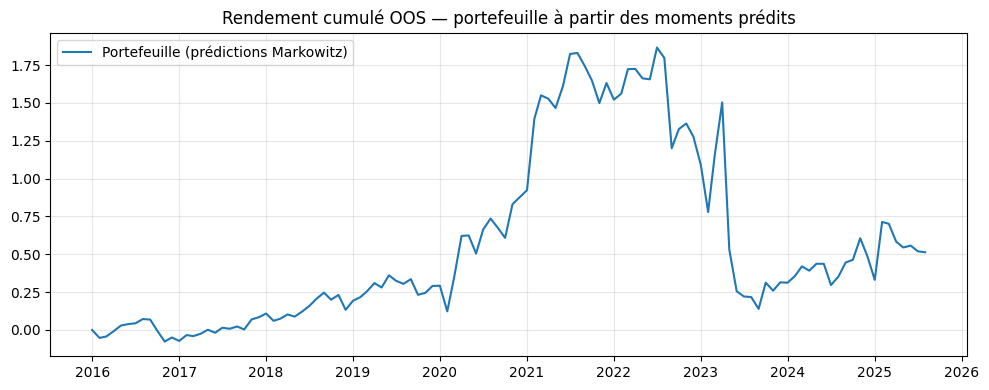

In [171]:
# Tu as déjà :
# - mu_pred, std_pred, cov_pred = predicted_moments_from_regimes(...)
# - indus_OOS : rendements réalisés OOS (proportions), mêmes colonnes que mean_ind_IS

# Option : fallback si certaines dates n'ont pas de cov (ex: moyenne des Σ_IS)
# Ici on prend la moyenne simple des covariances IS comme secours :
cov_fallback = None
# p.ex. cov_fallback = sum(cov_ind_IS.values()) / len(cov_ind_IS)

# 1) poids Markowitz prévus (tangence par défaut)
W_oos = weights_from_predicted_moments(
    mu_pred = mu_ind_pred,
    cov_pred = cov_ind_pred,          # peut être None si tu veux utiliser uniquement cov_fallback
    method = "tangency",
    rf = 0.0,
    cov_fallback = cov_fallback
)

# 2) rendements du portefeuille (pas de look-ahead)
r_oos = portfolio_returns_from_weights(W_oos, indus_OOS, shift_horizon=1)

# 3) (option) stats et graphe
ann = 12
mean_oos, vol_oos = r_oos.mean(), r_oos.std(ddof=1)
sharpe = (mean_oos*ann) / (vol_oos*np.sqrt(ann)) if vol_oos>0 else np.nan
print(f"Ann. mean={mean_oos*ann:.4f}  Ann. vol={vol_oos*np.sqrt(ann):.4f}  Ann. Sharpe={sharpe:.2f}")

plt.figure(figsize=(10,4))
plt.plot((1+r_oos).cumprod()-1, label="Portefeuille (prédictions Markowitz)")
plt.title("Rendement cumulé OOS — portefeuille à partir des moments prédits")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


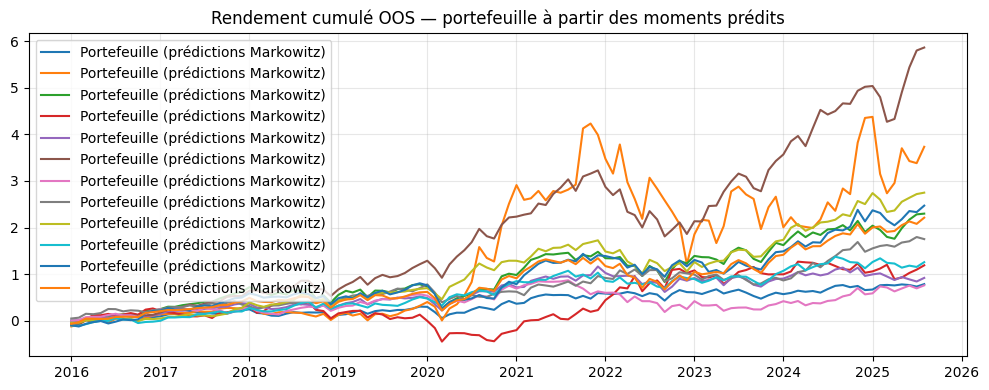

In [172]:
plt.figure(figsize=(10,4))
plt.plot((1+indus_OOS).cumprod()-1, label="Portefeuille (prédictions Markowitz)")
plt.title("Rendement cumulé OOS — portefeuille à partir des moments prédits")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

Ann. mean=-0.0205  Ann. vol=0.0593  Ann. Sharpe=-0.34


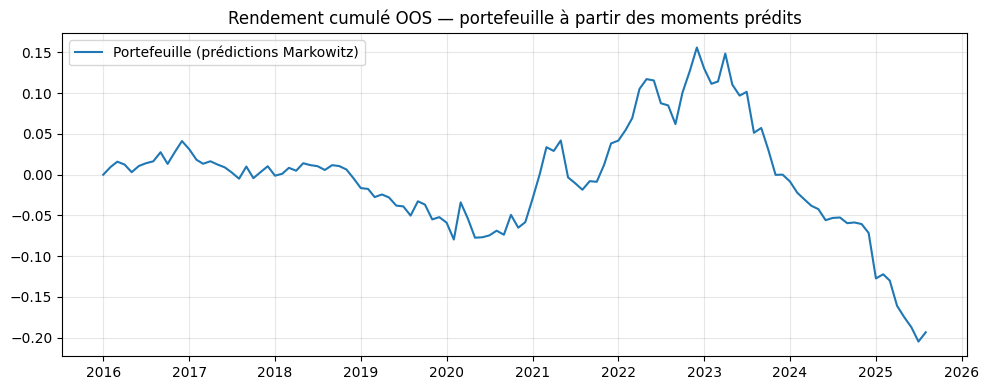

In [173]:

# Tu as déjà :
# - mu_pred, std_pred, cov_pred = predicted_moments_from_regimes(...)
# - indus_OOS : rendements réalisés OOS (proportions), mêmes colonnes que mean_ind_IS

# Option : fallback si certaines dates n'ont pas de cov (ex: moyenne des Σ_IS)
# Ici on prend la moyenne simple des covariances IS comme secours :
cov_fallback = None
# p.ex. cov_fallback = sum(cov_ind_IS.values()) / len(cov_ind_IS)

# 1) poids Markowitz prévus (tangence par défaut)
W_oos = weights_from_predicted_moments(
    mu_pred = mu_factors_pred,
    cov_pred = cov_factors_pred,          # peut être None si tu veux utiliser uniquement cov_fallback
    method = "tangency",
    rf = 0.0,
    cov_fallback = cov_fallback
)

# 2) rendements du portefeuille (pas de look-ahead)
r_oos = portfolio_returns_from_weights(W_oos, factors_OOS, shift_horizon=1)

# 3) (option) stats et graphe
ann = 12
mean_oos, vol_oos = r_oos.mean(), r_oos.std(ddof=1)
sharpe = (mean_oos*ann) / (vol_oos*np.sqrt(ann)) if vol_oos>0 else np.nan
print(f"Ann. mean={mean_oos*ann:.4f}  Ann. vol={vol_oos*np.sqrt(ann):.4f}  Ann. Sharpe={sharpe:.2f}")

plt.figure(figsize=(10,4))
plt.plot((1+r_oos).cumprod()-1, label="Portefeuille (prédictions Markowitz)")
plt.title("Rendement cumulé OOS — portefeuille à partir des moments prédits")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()
